##### NOTEBOOK ETUDE DE CAS 1                    

In [ ]:
## Author : TSAGHO Mariette
## School : ENSAI de Bruz
## Last modification : 13/01/2022

#### I. Chargement des libraries

In [630]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import LinearRegression

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor, early_stopping

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

import time
import pickle

In [631]:
sns.set(style="darkgrid")

##### I.1. Création des fonctions utiles pour la suite

In [632]:
## 1. Fonction permettant de représenter un barplot customizé

def barplot_cust(df, x_var, y_var, title, label_y="Fréquence(%)", lab=True):

    # Représentation du barplot
    fig, axes = plt.subplots( figsize=(15, 8), sharey=True)
    barplot = sns.barplot(ax=axes ,x = x_var,  y= y_var, data=df, color='#66b3ff')
    barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45)

    # Ajout des étiquettes pour les différentes barres
    nb_cat = df.shape[0]
    lab_bar = list(df[y_var])

    if lab:
        i = -1
        for bar in barplot.patches:
            if i<nb_cat-1:
                i+=1
                barplot.annotate(format(lab_bar[i], '.2f')+"%", (bar.get_x() + bar.get_width() / 2,
                                    bar.get_height()), ha='center', va='center',size=15, xytext=(0, -50),textcoords='offset points', color='white')

    # Labellisation des axes et ajout du titre
    axes.set_title(title, fontsize=15)
    axes.set_xlabel(xlabel=x_var, fontsize=15)
    axes.set_ylabel(ylabel=label_y, fontsize=15)

In [633]:
## 2. Fonction pour représenter le boxplot et le hisplot d'une variable quantitative

def histBox_cust(data, variable, color=0, log=False):

    colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99'] 
    
    if log:
        data[variable] = np.log(data[variable])

    fig, axes = plt.subplots(1,2, figsize=(30, 14)) 

    # Impression des statistiques de la variable
    print('********************************')
    print(data[variable].describe())
    
    # Représentation de l'histogramme et de la courbe de densité
    sns.histplot(ax=axes[0], data=data, x=variable, stat='density', kde=True, color=colors[color])
    axes[0].lines[0].set_color(colors[color+1])

    # Représentation du boxplot
    sns.boxplot(ax=axes[1], data=data, y=variable, color=colors[color+1])
    
    fig.tight_layout()
    plt.show()



In [634]:
## 3. Fonction pour construire et customizé le nuage de point entre une variable quantitative x_var et une liste d'une ou plusieurs autres variables quantitatives
def scatter(data, x_var, y_var, color=0, height=10, log=False):
    
    df = data.copy()
    colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99'] 
    fig, axes = plt.subplots(len(y_var), 1, figsize=(20, height)) 
    
    for i, elt in enumerate(y_var):
        if log:
            df[x_var] = np.log(df[x_var])
            df[elt] = np.log(df[elt])
        sns.scatterplot(ax = axes[i], data=df, x=x_var, y=elt)

In [635]:
## 4. Fonction pour représenter le camembert d'une ou plusieurs variables qualitatives
def custom_cam(data, var, title, num=2):
    
        colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
        fig, axes = plt.subplots(1, num, figsize=(30, 8), sharey=True)

        for axe, elt in enumerate(var):
                # Récupération des labels de catégories et de leurs effectifs
                labels = list(data[elt].value_counts().index) 
                sizes = list(data[elt].value_counts().values)

                # Faire ressortir l'effet 3D sur le camembert
                exp_list = [0.1]+[0]*(len(labels)-1) 
                explode = tuple(exp_list)

                # Représentation du camembert
                axes[axe].pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
                                shadow=True, startangle=90)

        # Labellisation des axes
        axes[0].set_title(title[0], fontsize=20)
        axes[1].set_title(title[1], fontsize=20)

In [ ]:
## 5. Fonction pour réaliser le onehot encoding (dichotomiser) des variables qualitatives

def onehot(onehot_df, df, column_name):
    onehot_df[column_name] = df[column_name]

    dummies = pd.get_dummies(onehot_df[column_name], prefix=column_name)
    onehot_df = onehot_df.join(dummies)

    onehot_df = onehot_df.drop([column_name], axis=1)
    onehot_df = onehot_df.iloc[:,:-1] 
    return onehot_df 

In [637]:
## 6. Simple fonction pour ressortir la liste des variables présentant des valeurs manquantes 
def na_var(df):
    miss = df.isna().sum()
    return miss[miss>0]

In [638]:
## 7. Fonction pour calculer le coefficient de détermination pour un modèle
def r2_score_custom(model, X, Y):
    y_pred = model.predict(X)
    return np.round(r2_score(Y, y_pred)*100,2)


In [639]:
## 8. Fonction pour représenter le barplot d'importance des variables d'un modèle de type bagging ou boosting
def feature_importance(model):   
    importance_df = pd.DataFrame({
        'Variable': X.columns,
        'Importance': model.best_estimator_.feature_importances_
    }).sort_values('Importance', ascending=False)

    barplot_cust(importance_df, x_var="Variable", y_var="Importance", title="Importance des variables", lab=False, label_y='Score importance')


#### II. Chargement et exploration des données

In [640]:
df_agence = pd.read_csv("F:/Capgemini invent/agence.csv",header=0)        
df_insee = pd.read_csv("F:/Capgemini invent/insee_commune.csv",header=0)         
df_localisation = pd.read_csv("F:/Capgemini invent/localisation_commune.csv",header=0)
df_france = pd.read_csv("F:/Capgemini invent/france.csv",header=0)

C:\Users\douan\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (0,3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\douan\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (2,5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [641]:
## Dimension des bases de données
print(df_agence.shape,  df_insee.shape,  df_localisation.shape, df_france.shape)

(4000, 13) (34953, 36) (39192, 7) (2641120, 46)


##### a. Base agence

In [642]:
df_agence.head(2)

,date_mutation,valeur_fonciere,code_postal,nom_commune,id_parcelle,type_local,surface_reelle_bati,surface_terrain,nombre_pieces_principales,agent,prixcible,prixvente_initial,evaluation_agent
0,2014-01-03,210000.0,31000,Toulouse,31555815AC0067,Appartement,70.0,70.0,3.0,1,206000,216000,Renove
1,2014-02-07,162500.0,31500,Toulouse,31555807AB0464,Appartement,67.0,67.0,3.0,1,155000,163000,Ancien


In [643]:
na_var(df_agence)

Series([], dtype: int64)

In [644]:
df_agence.dtypes

date_mutation                 object
valeur_fonciere              float64
code_postal                    int64
nom_commune                   object
id_parcelle                   object
type_local                    object
surface_reelle_bati          float64
surface_terrain              float64
nombre_pieces_principales    float64
agent                          int64
prixcible                      int64
prixvente_initial              int64
evaluation_agent              object
dtype: object

##### b. Base insee

In [645]:
df_insee.head(2)

,CODGEO,LIBGEO,REG,DEP,P16_POP,P11_POP,SUPERF,NAIS1116,DECE1116,P16_MEN,...,P16_ACT1564,ETTOT15,ETAZ15,ETBE15,ETFZ15,ETGU15,ETGZ15,ETOQ15,ETTEF115,ETTEFP1015
0,01001,L'Abergement-Clémenciat,84,01,767,780,15.95,41,25,306.0,...,376.0,50.0,11.0,3.0,5.0,24.0,5.0,7.0,10.0,0.0
1,01002,L'Abergement-de-Varey,84,01,243,234,9.15,21,7,101.0,...,123.0,19.0,2.0,3.0,0.0,11.0,3.0,3.0,2.0,0.0


In [646]:
na_var(df_insee)

NBMENFISC16     3593
PIMP16         29705
MED16           3593
TP6016         30626
P11_EMPLT          3
ETTOT15            1
ETAZ15             1
ETBE15             1
ETFZ15             1
ETGU15             1
ETGZ15             1
ETOQ15             1
ETTEF115           1
ETTEFP1015         1
dtype: int64

In [647]:
df_insee.dtypes

CODGEO            object
LIBGEO            object
REG                int64
DEP               object
P16_POP            int64
P11_POP            int64
SUPERF           float64
NAIS1116           int64
DECE1116           int64
P16_MEN          float64
NAISD18            int64
DECESD18           int64
P16_LOG          float64
P16_RP           float64
P16_RSECOCC      float64
P16_LOGVAC       float64
P16_RP_PROP      float64
NBMENFISC16      float64
PIMP16           float64
MED16            float64
TP6016           float64
P16_EMPLT        float64
P16_EMPLT_SAL    float64
P11_EMPLT        float64
P16_POP1564      float64
P16_CHOM1564     float64
P16_ACT1564      float64
ETTOT15          float64
ETAZ15           float64
ETBE15           float64
ETFZ15           float64
ETGU15           float64
ETGZ15           float64
ETOQ15           float64
ETTEF115         float64
ETTEFP1015       float64
dtype: object

##### c. Base localisation

In [648]:
df_localisation.head(2)

,Code_commune_INSEE,Nom_commune,Code_postal,Ligne_5,Libellé_d_acheminement,Libell_d_acheminement,coordonnees_gps
0,01001,L ABERGEMENT CLEMENCIAT,1400,NaN,L ABERGEMENT CLEMENCIAT,L ABERGEMENT CLEMENCIAT,"46.1534255214,4.92611354223"
1,01005,AMBERIEUX EN DOMBES,1330,NaN,AMBERIEUX EN DOMBES,AMBERIEUX EN DOMBES,"45.9961799872,4.91227250796"


##### d. Base France

In [649]:
df_france.head(2)

,date_mutation,valeur_fonciere,adresse_code_voie,code_postal,nom_commune,code_commune,id_parcelle,type_local,surface_reelle_bati,surface_terrain,...,carreau_Ind_11_17,carreau_Ind_18_24,carreau_Ind_25_39,carreau_Ind_40_54,carreau_Ind_55_64,carreau_Ind_65_79,carreau_Ind_80p,carreau_Ind_inc,carreau_I_pauv,carreau_t_maille
0,2014-01-09,251500.0,0006,1310,Polliat,1301,01301000AH0260,Maison,147.0,1501.0,...,35.5,30.8,74.2,86.0,86.0,55.0,20.0,7.0,0,1000
1,2017-06-12,325000.0,0241,1310,Polliat,1301,01301000AH0169,Maison,132.0,896.0,...,35.5,30.8,74.2,86.0,86.0,55.0,20.0,7.0,0,1000


In [650]:
na_var(df_france)

Series([], dtype: int64)

In [651]:
df_france.dtypes

date_mutation                 object
valeur_fonciere              float64
adresse_code_voie             object
code_postal                    int64
nom_commune                   object
code_commune                  object
id_parcelle                   object
type_local                    object
surface_reelle_bati          float64
surface_terrain              float64
nombre_pieces_principales    float64
longitude                    float64
latitude                     float64
departement                    int64
index_right                    int64
carreau_Id_carr_n             object
carreau_Ind                  float64
carreau_Men                  float64
carreau_Men_pauv             float64
carreau_Men_1ind             float64
carreau_Men_5ind             float64
carreau_Men_prop             float64
carreau_Men_fmp              float64
carreau_Ind_snv              float64
carreau_Men_surf             float64
carreau_Men_coll             float64
carreau_Men_mais             float64
c

##### e. Fusion des base agence et france

In [652]:
## L'identifiant commun aux deux bases est obtenu en concatenant les variables suivantes : nom_commune, id_parcelle et date_mutation
df_france['id'] = df_france['nom_commune']+df_france['id_parcelle']+df_france['date_mutation']

df_france_1 = df_france.drop(['date_mutation', 'nom_commune', 'valeur_fonciere', 'adresse_code_voie', 'id_parcelle', 'code_postal','code_commune','type_local', 
                            'surface_reelle_bati','surface_terrain', 'nombre_pieces_principales','carreau_Id_carr_n','longitude', 'latitude', 'departement', 'index_right'], axis=1)

df_agence['id'] = df_agence['nom_commune']+df_agence['id_parcelle']+df_agence['date_mutation']
df_agence_1 = df_agence.drop(['id_parcelle', 'date_mutation','agent'], axis=1)

df_merge_1 = pd.merge(df_agence_1,df_france_1, how='inner', on='id')
df_merge_1 = df_merge_1.drop(['id',], axis=1)

## Les variables supprimées dans la base france sont celles qui se retrouvent dans la base agence (ex : surface_terrain) ou qui ne seront pas utilisées pour l'analyse (ex : longitude)

##### f. Fusion des base agence, france et insee

In [653]:
## Fusion des bases df_merge et df_insee
df_insee_1 = df_insee.copy()
df_insee_1['id'] = df_insee_1['LIBGEO'] + df_insee_1['DEP'].astype(str)
df_insee_1 = df_insee_1.drop(['LIBGEO','CODGEO', 'DEP', 'REG', 'DEP'], axis=1)

In [654]:
## Fusion finale
df_merge_1['id'] = df_merge_1['nom_commune']+df_merge_1['code_postal'].map(lambda x: str(x)[:2])
df_merge = pd.merge(df_merge_1, df_insee_1, how='inner', on='id')
df_merge = df_merge.drop('id', axis=1)

In [655]:

na_var(df_merge)

PIMP16     43
TP6016    105
dtype: int64

In [656]:
df_merge = df_merge.drop(['PIMP16','TP6016', 'code_postal'],axis=1)

In [657]:
df_merge.shape

(4000, 69)

##### g. Sélection des variables des bases france et insee par régression LASSO

In [658]:
## variable cible et prédicteurs issues des bases opendata (France et Insee)

y_opendata = df_merge['prixcible']  

opendata_var =list(set(list(df_france_1.columns)  + list(df_insee_1.columns)))
opendata_var = [elt for elt in opendata_var if elt not in ['PIMP16','TP6016','id', 'carreau_I_pauv']]   # carreau_I_pauv est nulle pour tout le monde
X_opendata = df_merge[opendata_var]

## Normalisation des données 
scaler_sc = StandardScaler()
y_opendata_s = (y_opendata.values-np.mean(y_opendata))/np.std(y_opendata)
X_opendata_s = scaler_sc.fit_transform(X_opendata)

## NB 1 : Le centrage de la variable cible permet d'éviter de pénaliser l'intercept de la régression
## NB 2 : La normalisation permet de ramener toutes les variables à une même échelle et éviter ainsi d'accorder plus de poids à l'une d'elle pendant la sélection
 

In [659]:
## Exécution d'une régression Lasso avec cross validation
parameter = [i/100 for i in np.arange(1,100)] 
mod_lasso = Lasso(fit_intercept=False, normalize=False, max_iter=1000000, random_state=12)
opt_mod_lasso = LassoCV(alphas=parameter, cv=8, n_jobs=-1, fit_intercept=False, max_iter=100000, random_state=12)
opt_mod_lasso.fit(X_opendata_s, y_opendata_s)
opt_mod_lasso.alpha_

0.01

In [660]:
## Récupération des variables à priori pertinentes
coef = pd.DataFrame(opt_mod_lasso.coef_, index=list(X_opendata.columns))
coef = coef.reset_index()
coef.columns = ['variable','coefficient']
coef_select = coef.loc[np.abs(coef.coefficient)>0]
coef_select

## NB 1 : On conserve uniquement les variables donc le coefficient n'est pas nul

,variable,coefficient
2,carreau_Log_ap90,-0.006008
4,carreau_Log_45_70,0.086696
11,carreau_Ind_inc,0.297134
14,carreau_Ind_6_10,-0.032600
22,carreau_Men_1ind,-0.205563
25,carreau_Ind_80p,-0.039550
26,carreau_Men_pauv,-0.105922
33,carreau_t_maille,0.002986
40,P16_LOGVAC,0.034277
53,ETAZ15,0.024558


In [661]:
## Suppression des variables non sélectionnées par la régression LASSO de la base df_merge 
var_sup =  list(set(list(X_opendata.columns)).difference(set(coef_select['variable']))) + ['carreau_I_pauv']
df_merge_new = df_merge.drop(var_sup, axis=1)

In [662]:
df_merge_new.head()

,valeur_fonciere,nom_commune,type_local,surface_reelle_bati,surface_terrain,nombre_pieces_principales,prixcible,prixvente_initial,evaluation_agent,carreau_Men_pauv,...,carreau_Log_45_70,carreau_Log_ap90,carreau_Ind_6_10,carreau_Ind_18_24,carreau_Ind_80p,carreau_Ind_inc,carreau_t_maille,P16_LOGVAC,MED16,ETAZ15
0,210000.0,Toulouse,Appartement,70.0,70.0,3.0,206000,216000,Renove,39.0,...,20.0,15.0,31.0,35.0,21.0,19.0,200,23542.431482,20430.0,82.0
1,162500.0,Toulouse,Appartement,67.0,67.0,3.0,155000,163000,Ancien,33.0,...,55.0,15.0,17.5,19.0,17.0,20.0,200,23542.431482,20430.0,82.0
2,381000.0,Toulouse,Appartement,100.0,100.0,4.0,391000,411000,Renove,6.0,...,20.0,9.0,15.0,3.0,19.0,9.0,200,23542.431482,20430.0,82.0
3,159900.0,Toulouse,Appartement,57.0,57.0,3.0,170000,178000,Renove,231.0,...,34.0,1271.0,241.5,287.0,46.0,56.0,1000,23542.431482,20430.0,82.0
4,58000.0,Toulouse,Appartement,34.0,34.0,2.0,62000,65000,Ancien,435.0,...,22.0,721.0,289.5,301.5,118.0,84.0,1000,23542.431482,20430.0,82.0


#### III. Analyse descriptive univariée

##### a. Variable quantitative de la base principale (agence)

********************************
count    4.000000e+03
mean     2.161692e+05
std      1.379113e+05
min      2.400000e+04
25%      1.157500e+05
50%      1.870000e+05
75%      2.780000e+05
max      1.532000e+06
Name: prixcible, dtype: float64


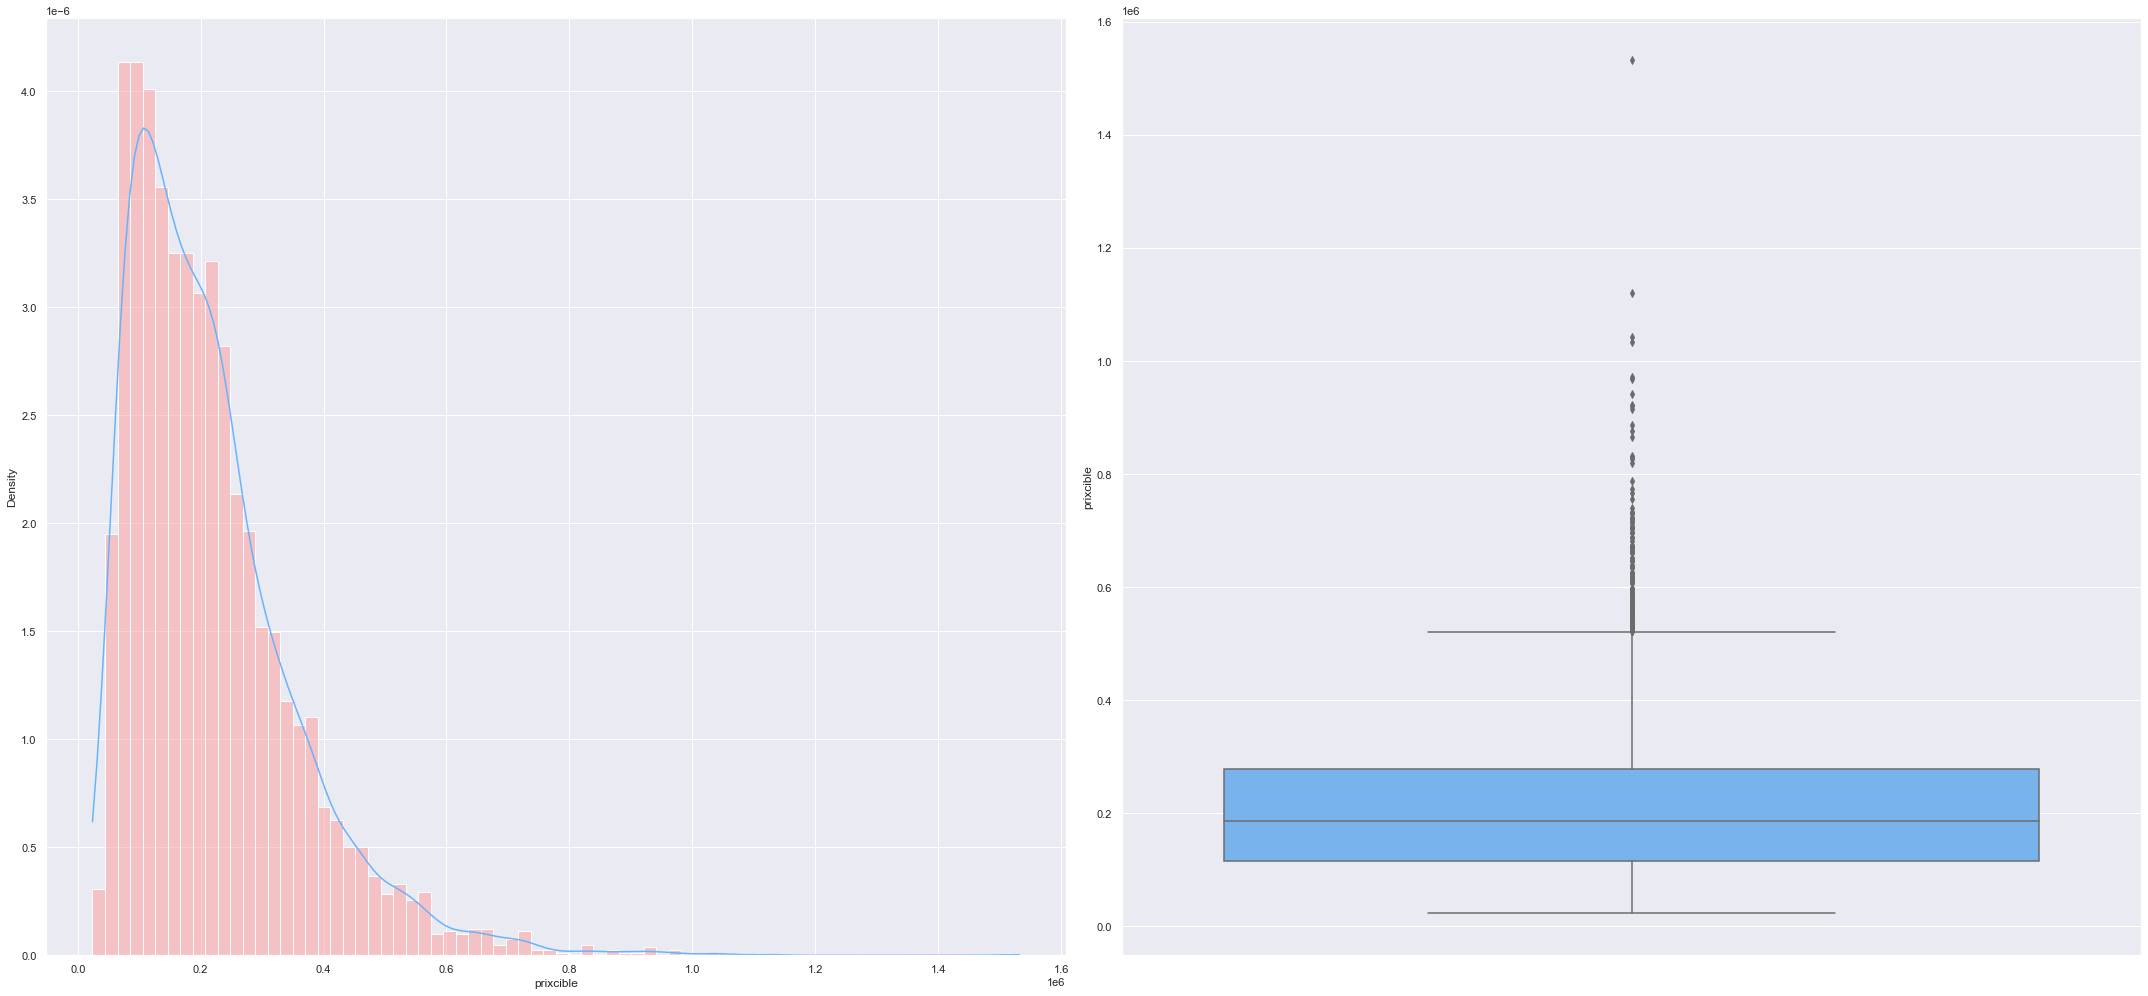

In [663]:
histBox_cust(df_merge_new, variable='prixcible', color=0, log=False)

********************************
count    4.000000e+03
mean     2.270006e+05
std      1.448099e+05
min      2.500000e+04
25%      1.217500e+05
50%      1.960000e+05
75%      2.920000e+05
max      1.609000e+06
Name: prixvente_initial, dtype: float64


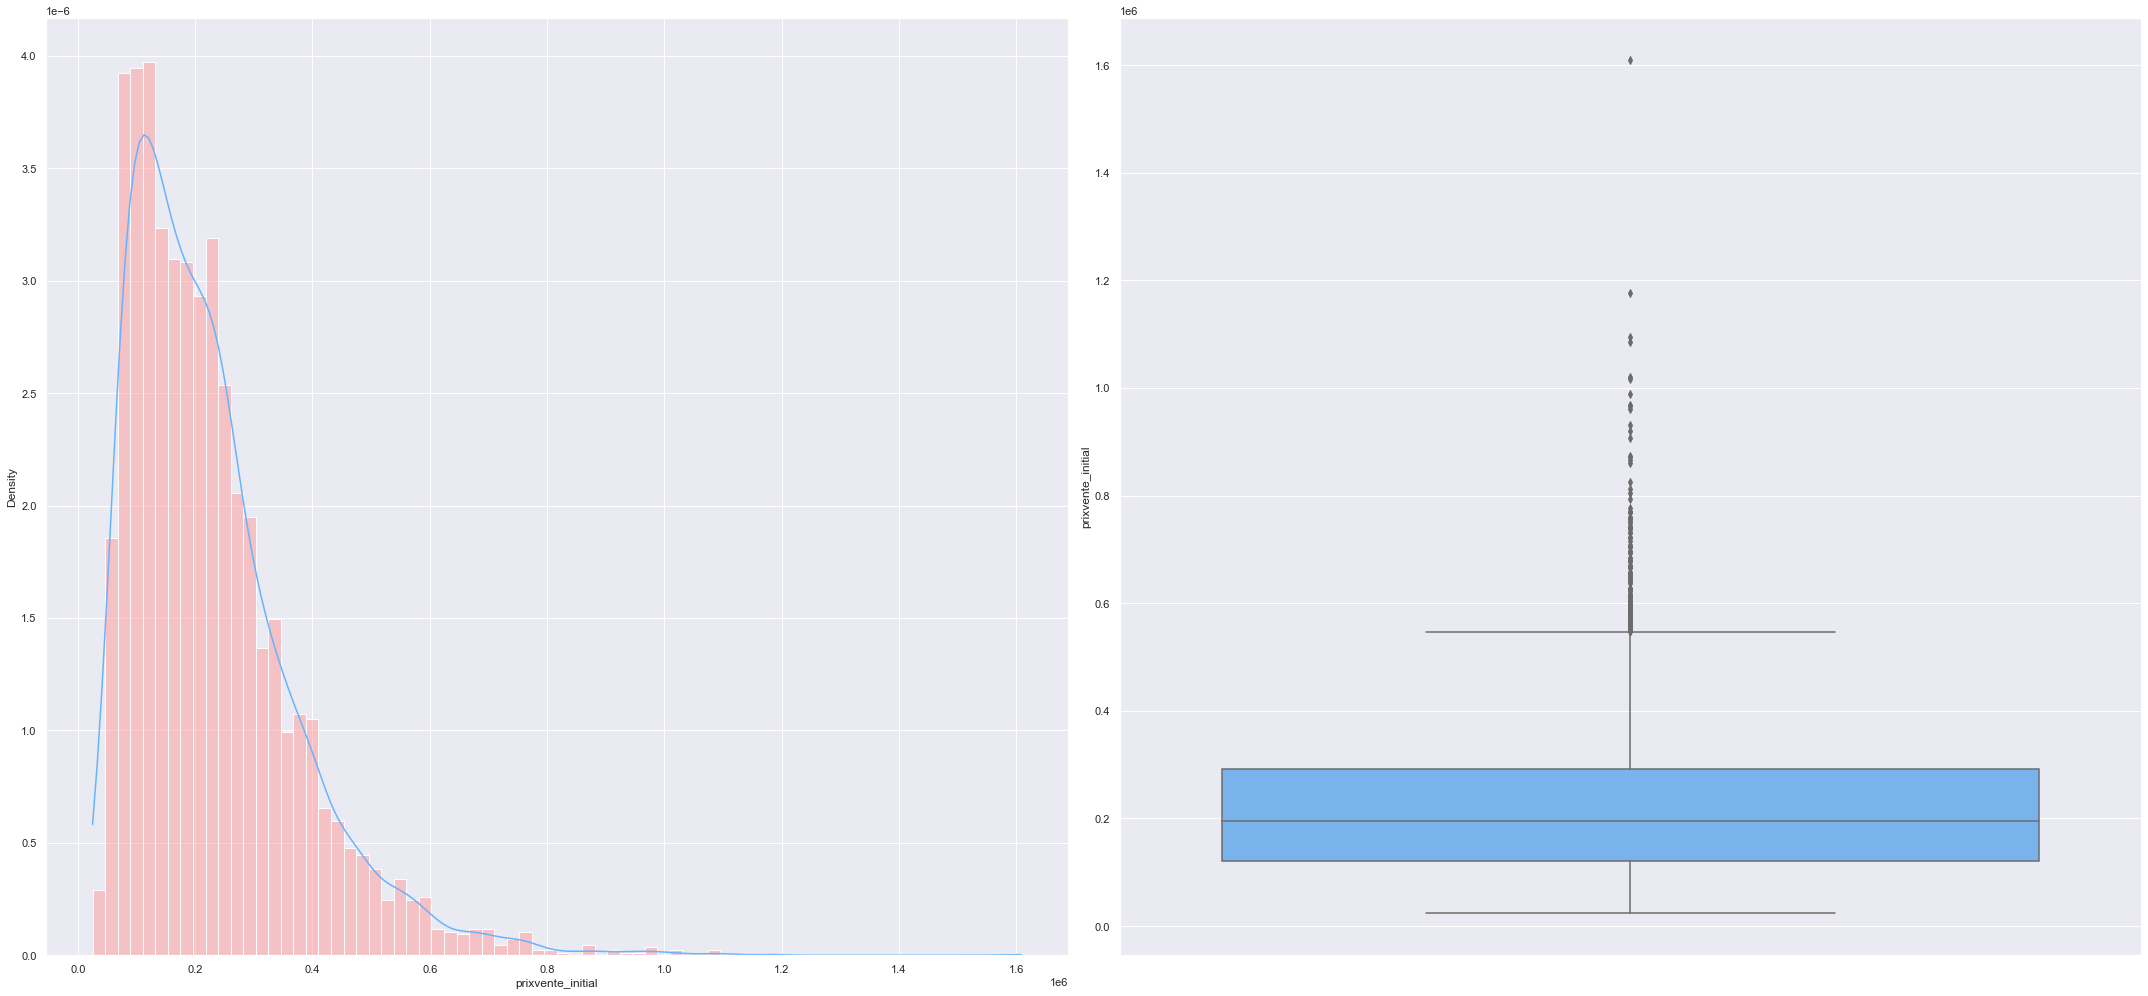

In [664]:
histBox_cust(df_merge_new, variable='prixvente_initial', color=0, log=False)

********************************
count    4.000000e+03
mean     2.124442e+05
std      1.350077e+05
min      2.200000e+04
25%      1.148075e+05
50%      1.830000e+05
75%      2.735090e+05
max      1.500000e+06
Name: valeur_fonciere, dtype: float64


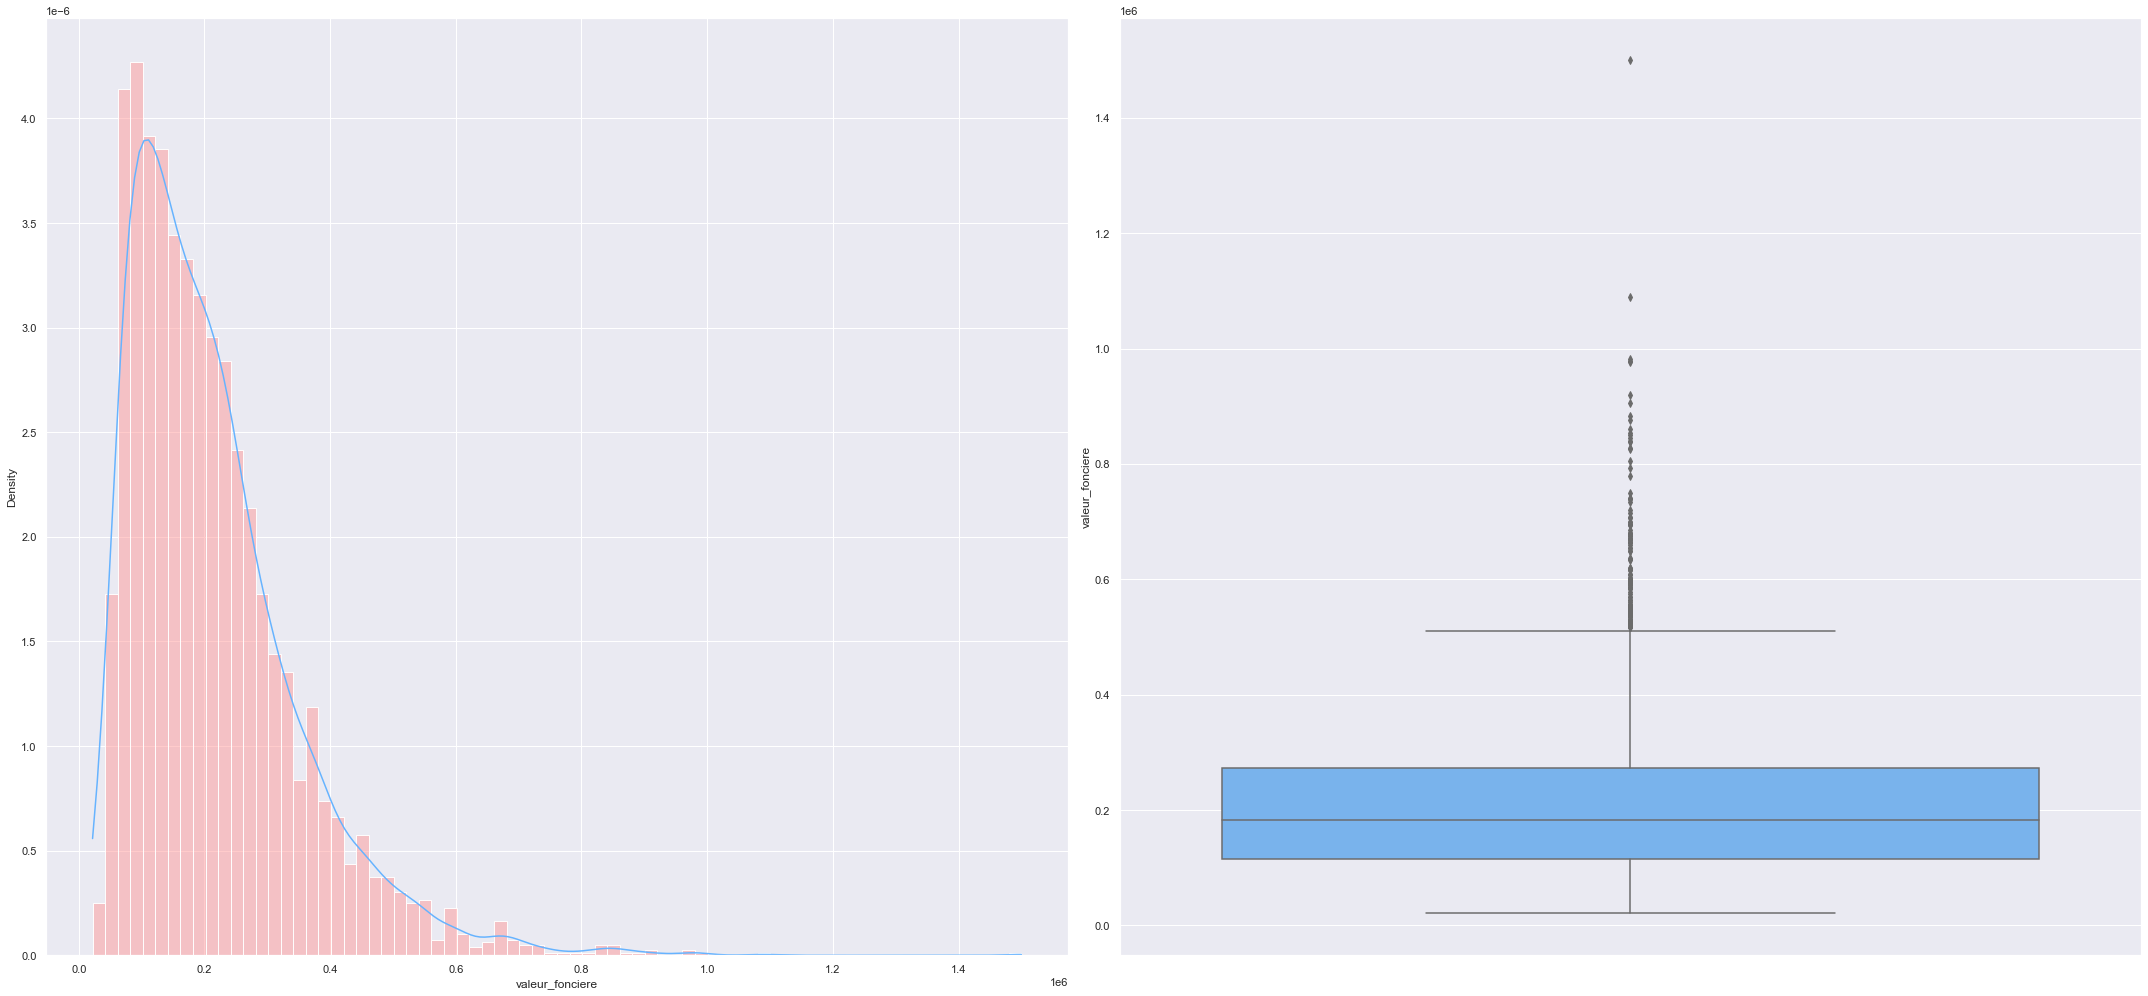

In [665]:
histBox_cust(df_merge_new, variable='valeur_fonciere', color=0, log=False)

********************************
count    4000.000000
mean      280.131750
std       408.480567
min         8.000000
25%        45.000000
50%        81.000000
75%       404.000000
max      7432.000000
Name: surface_terrain, dtype: float64


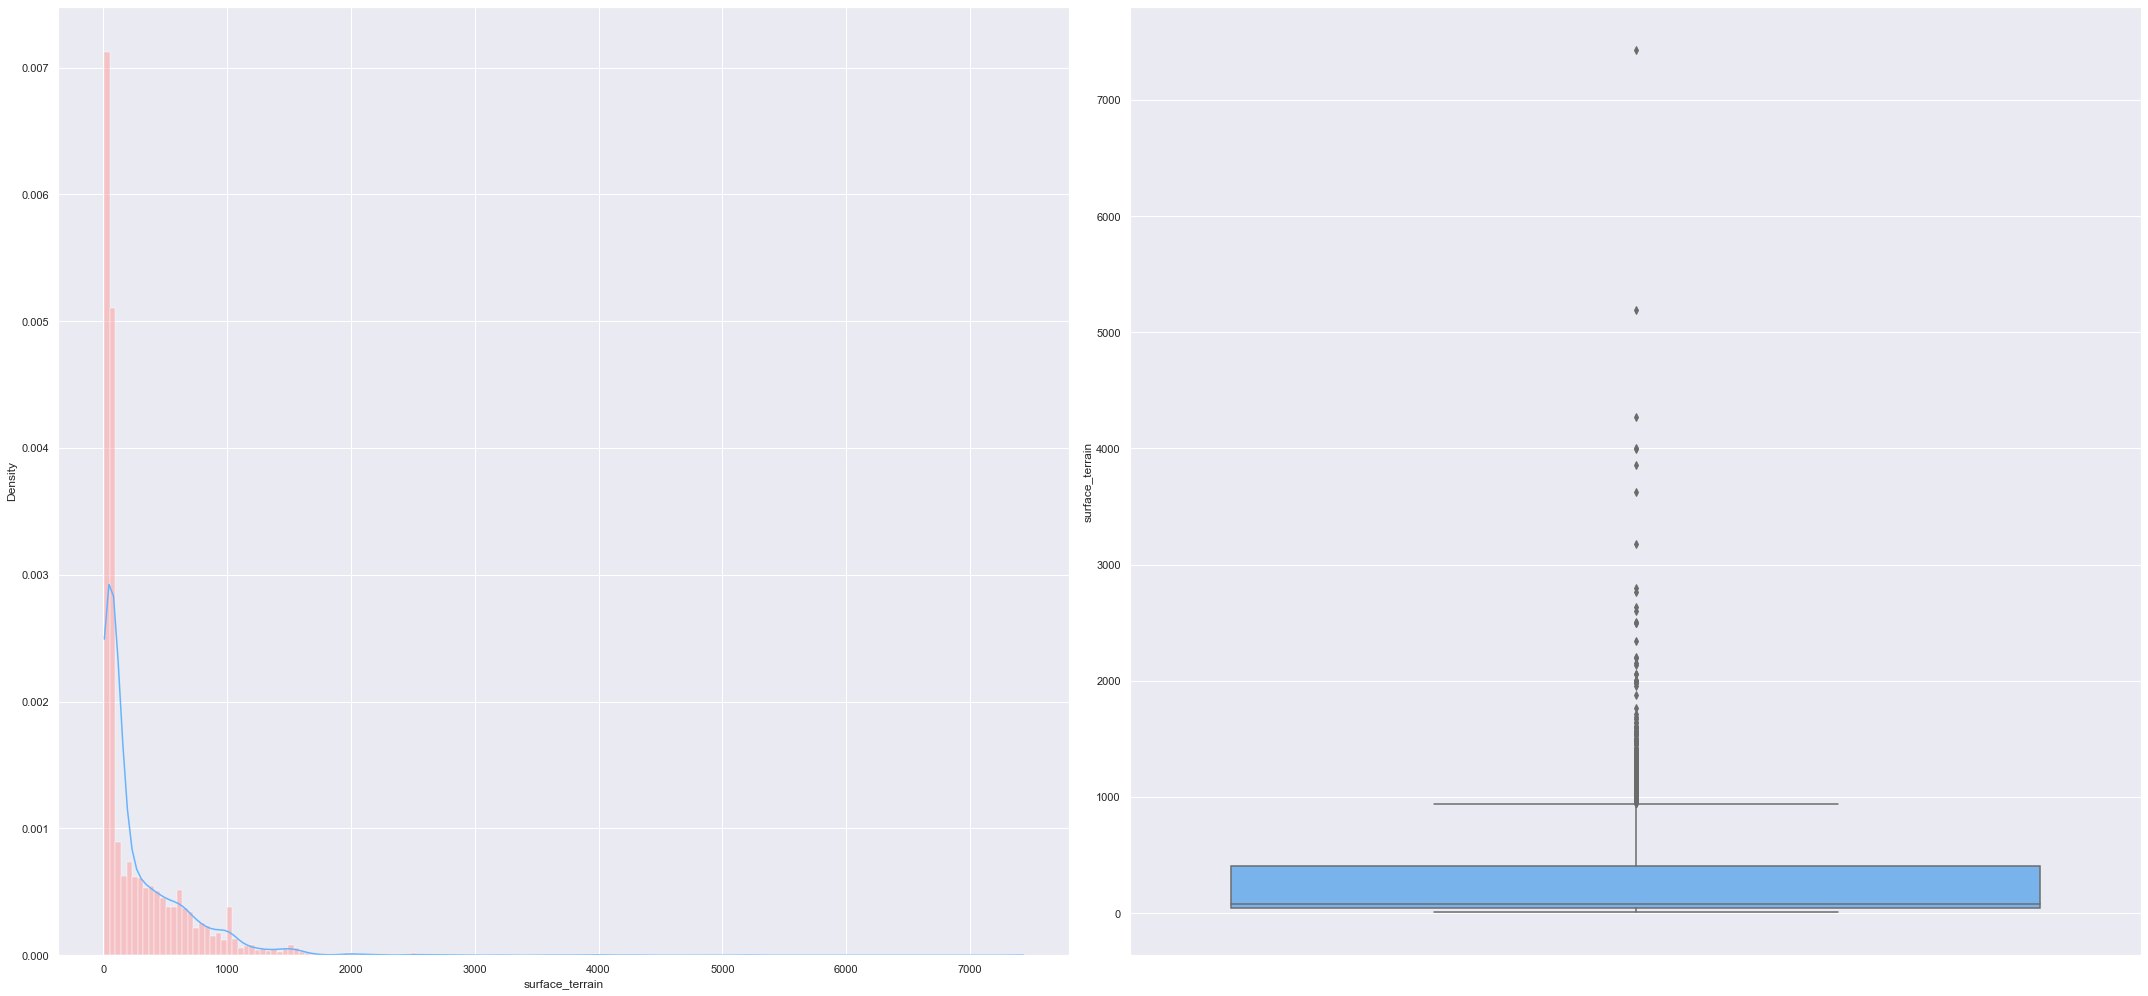

In [666]:
histBox_cust(df_merge_new, variable='surface_terrain', color=0, log=False)

********************************
count    4000.000000
mean       77.036250
std        42.930131
min        12.000000
25%        45.000000
50%        70.500000
75%        99.000000
max       385.000000
Name: surface_reelle_bati, dtype: float64


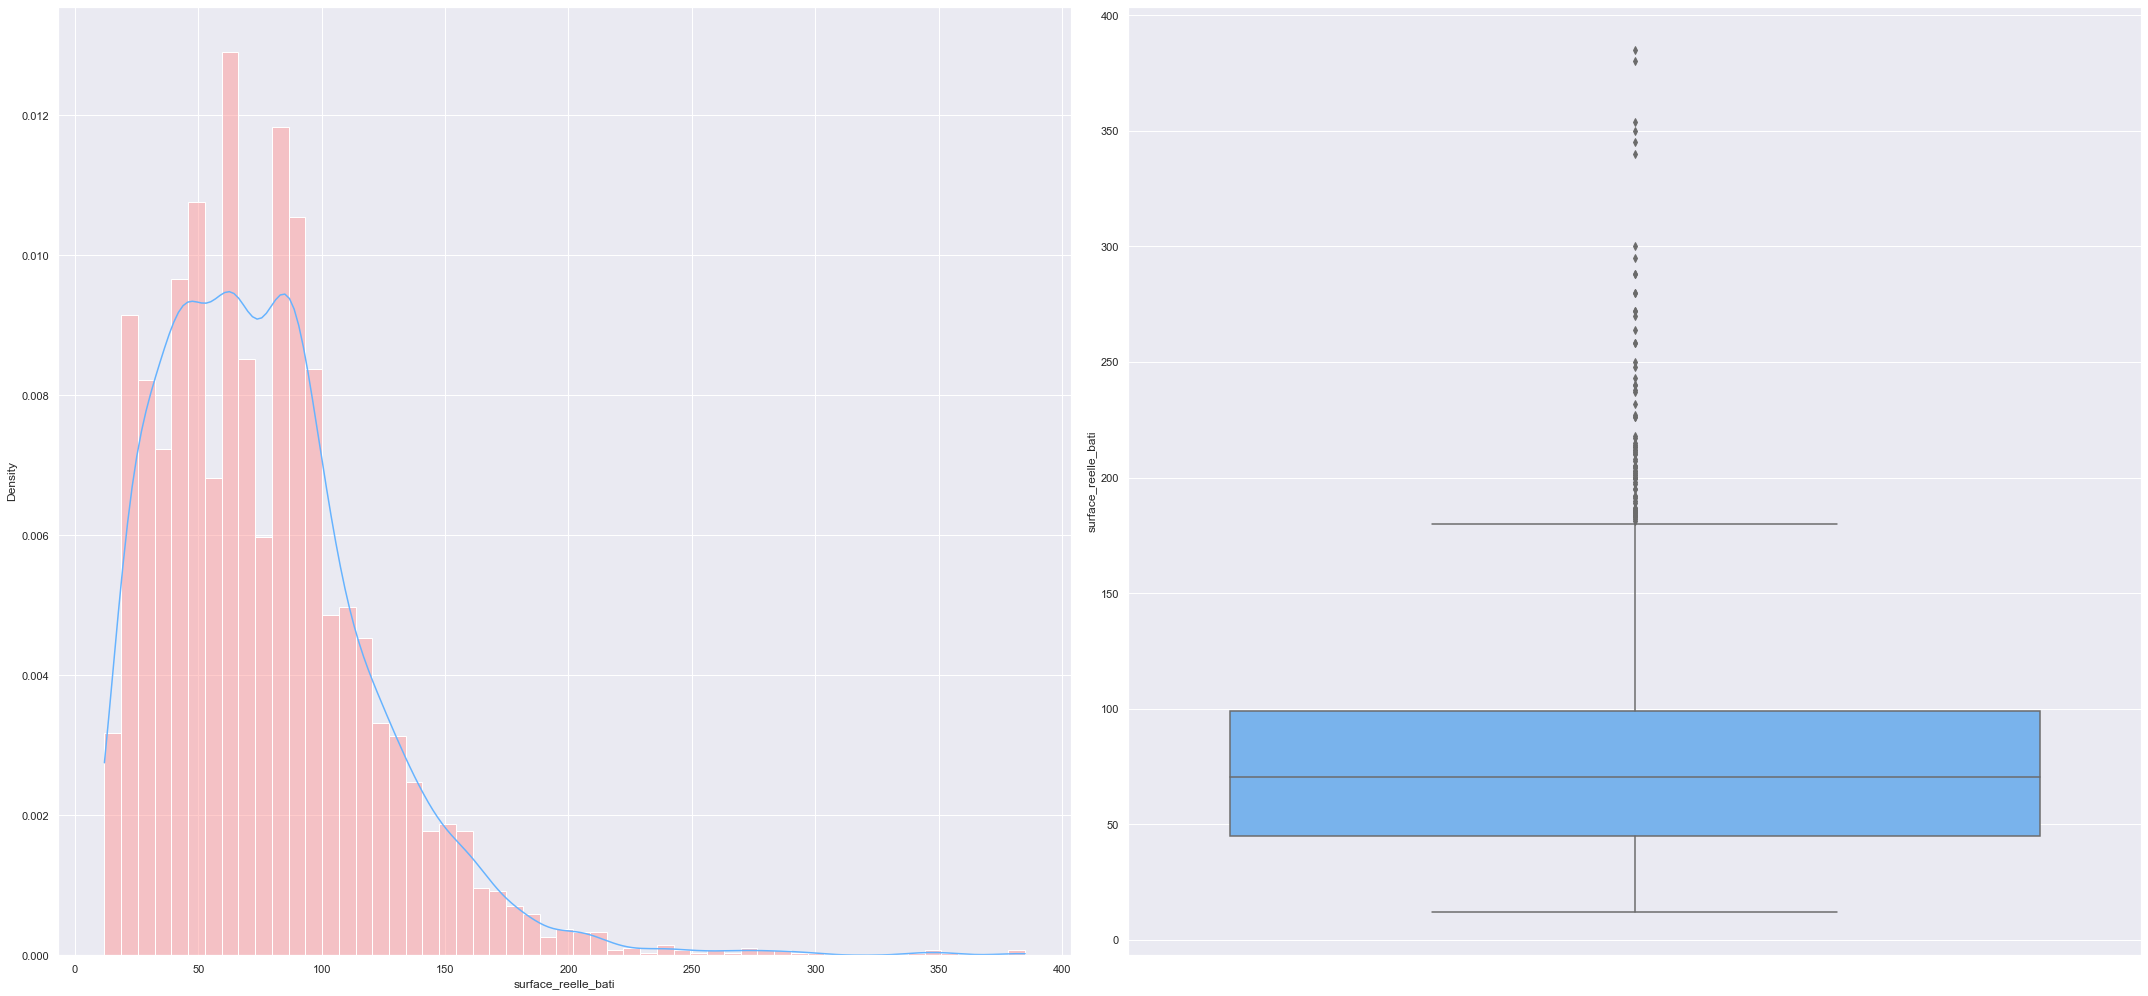

In [667]:
histBox_cust(df_merge_new, variable='surface_reelle_bati', color=0, log=False)

********************************
count    4000.000000
mean        3.343750
std         1.555214
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        11.000000
Name: nombre_pieces_principales, dtype: float64


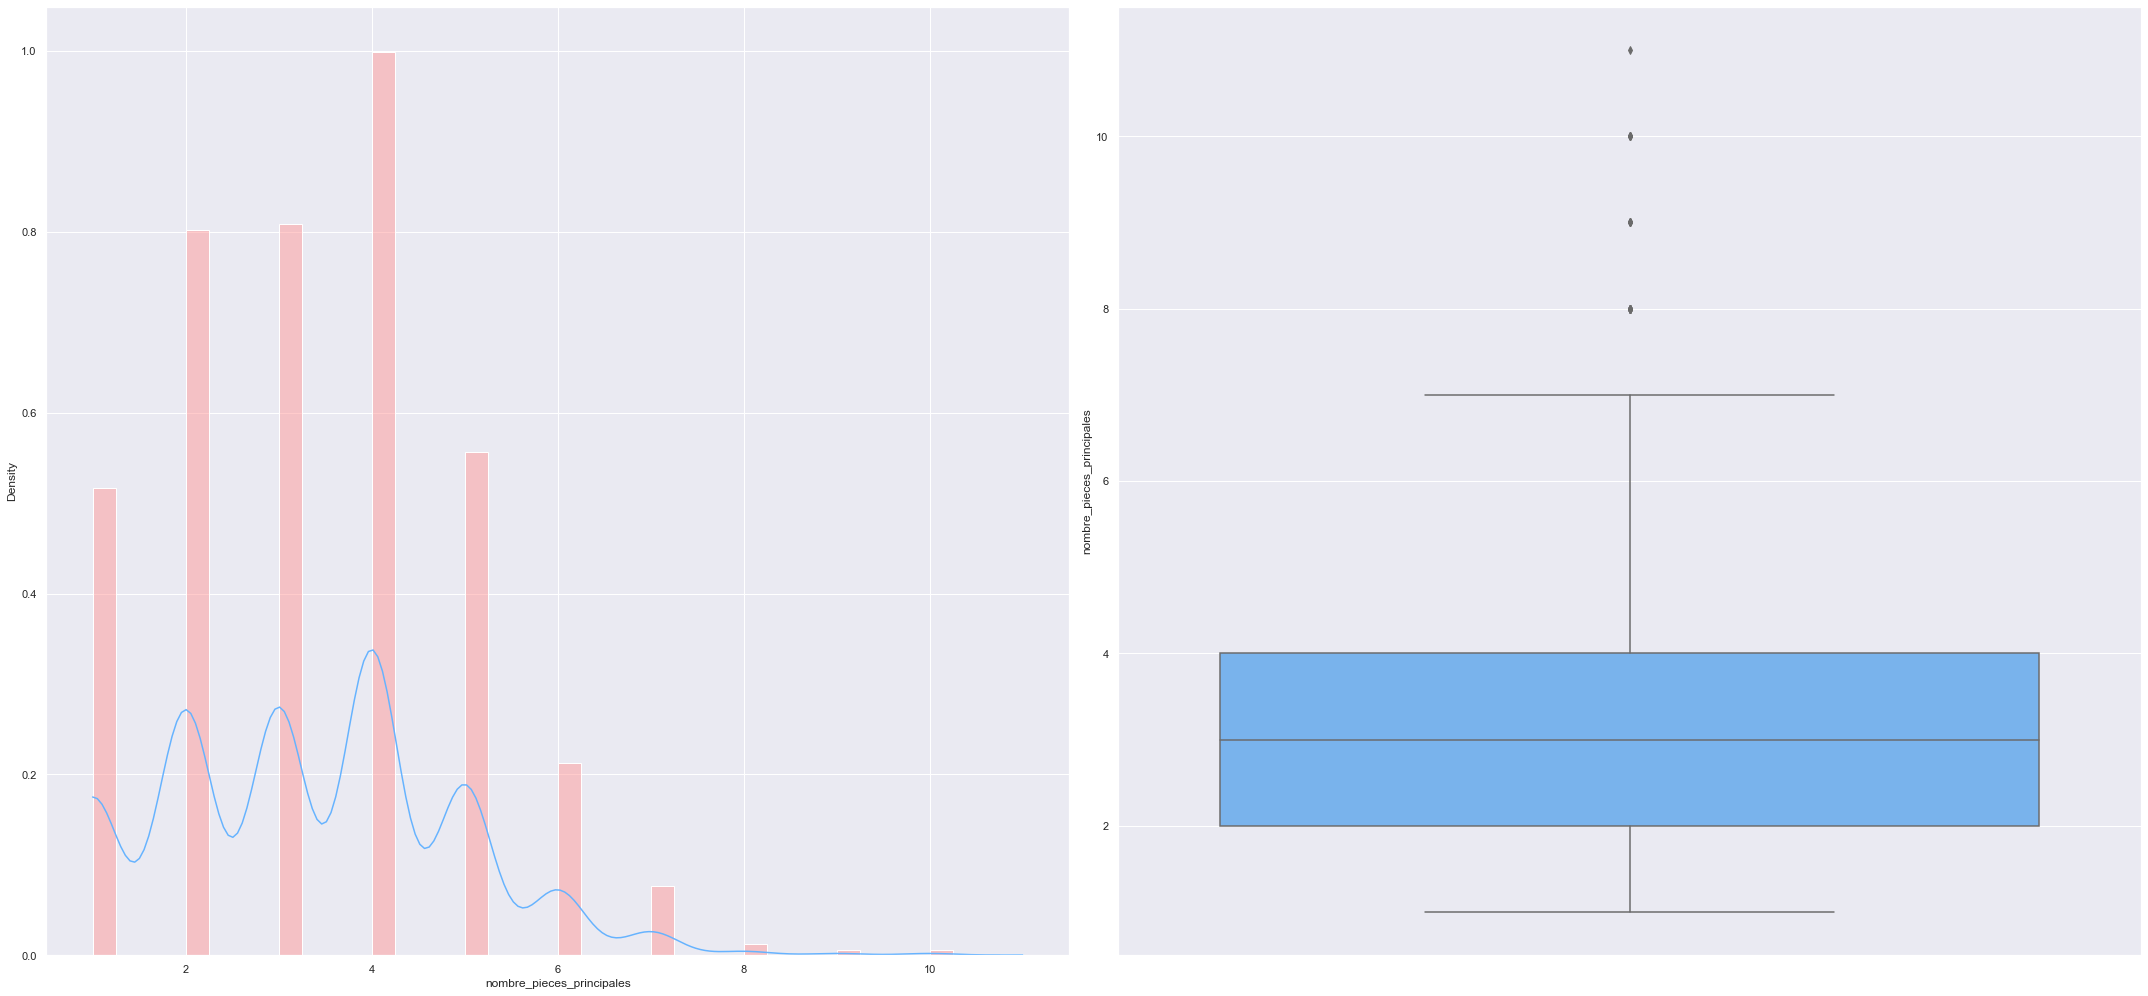

In [668]:
histBox_cust(df_merge_new, variable='nombre_pieces_principales', color=0, log=False)

##### b. Variable qualitative de la base principale (agence)

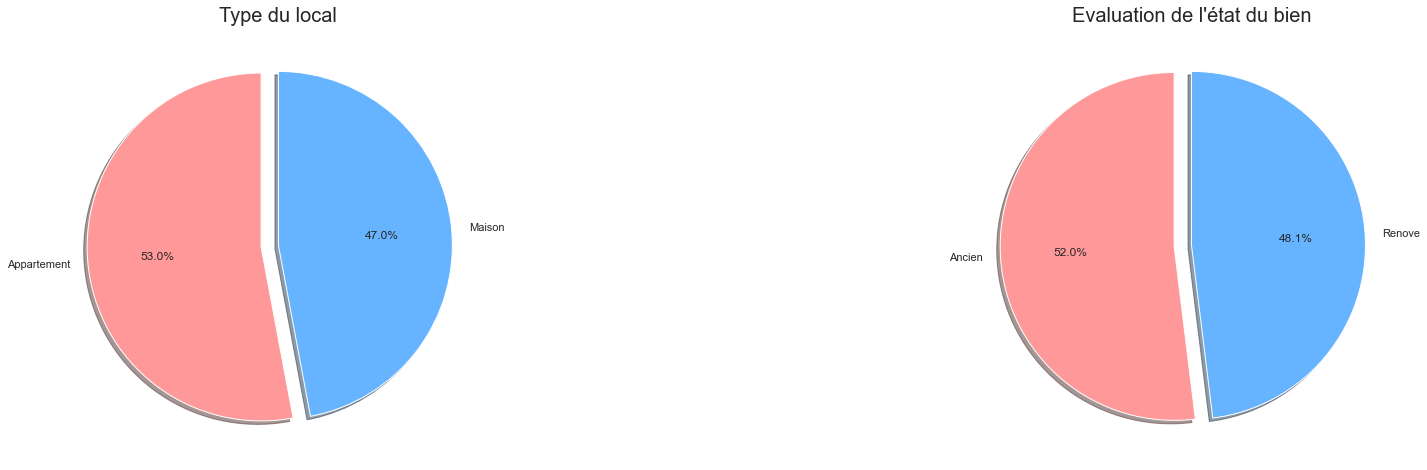

In [669]:
custom_cam(df_agence, title=["Type du local", "Evaluation de l'état du bien"], var=['type_local','evaluation_agent'])

##### c. Variables sélectionnées par la régression LASSO des bases France et Insee

In [670]:
var_sel = list(coef_select['variable'])    
var_sel

['carreau_Log_ap90',
 'carreau_Log_45_70',
 'carreau_Ind_inc',
 'carreau_Ind_6_10',
 'carreau_Men_1ind',
 'carreau_Ind_80p',
 'carreau_Men_pauv',
 'carreau_t_maille',
 'P16_LOGVAC',
 'ETAZ15',
 'carreau_Ind_18_24',
 'MED16']

********************************
count    4000.000000
mean      537.215000
std       554.965398
min         0.000000
25%        87.750000
50%       350.000000
75%       815.000000
max      2298.900000
Name: carreau_Log_ap90, dtype: float64


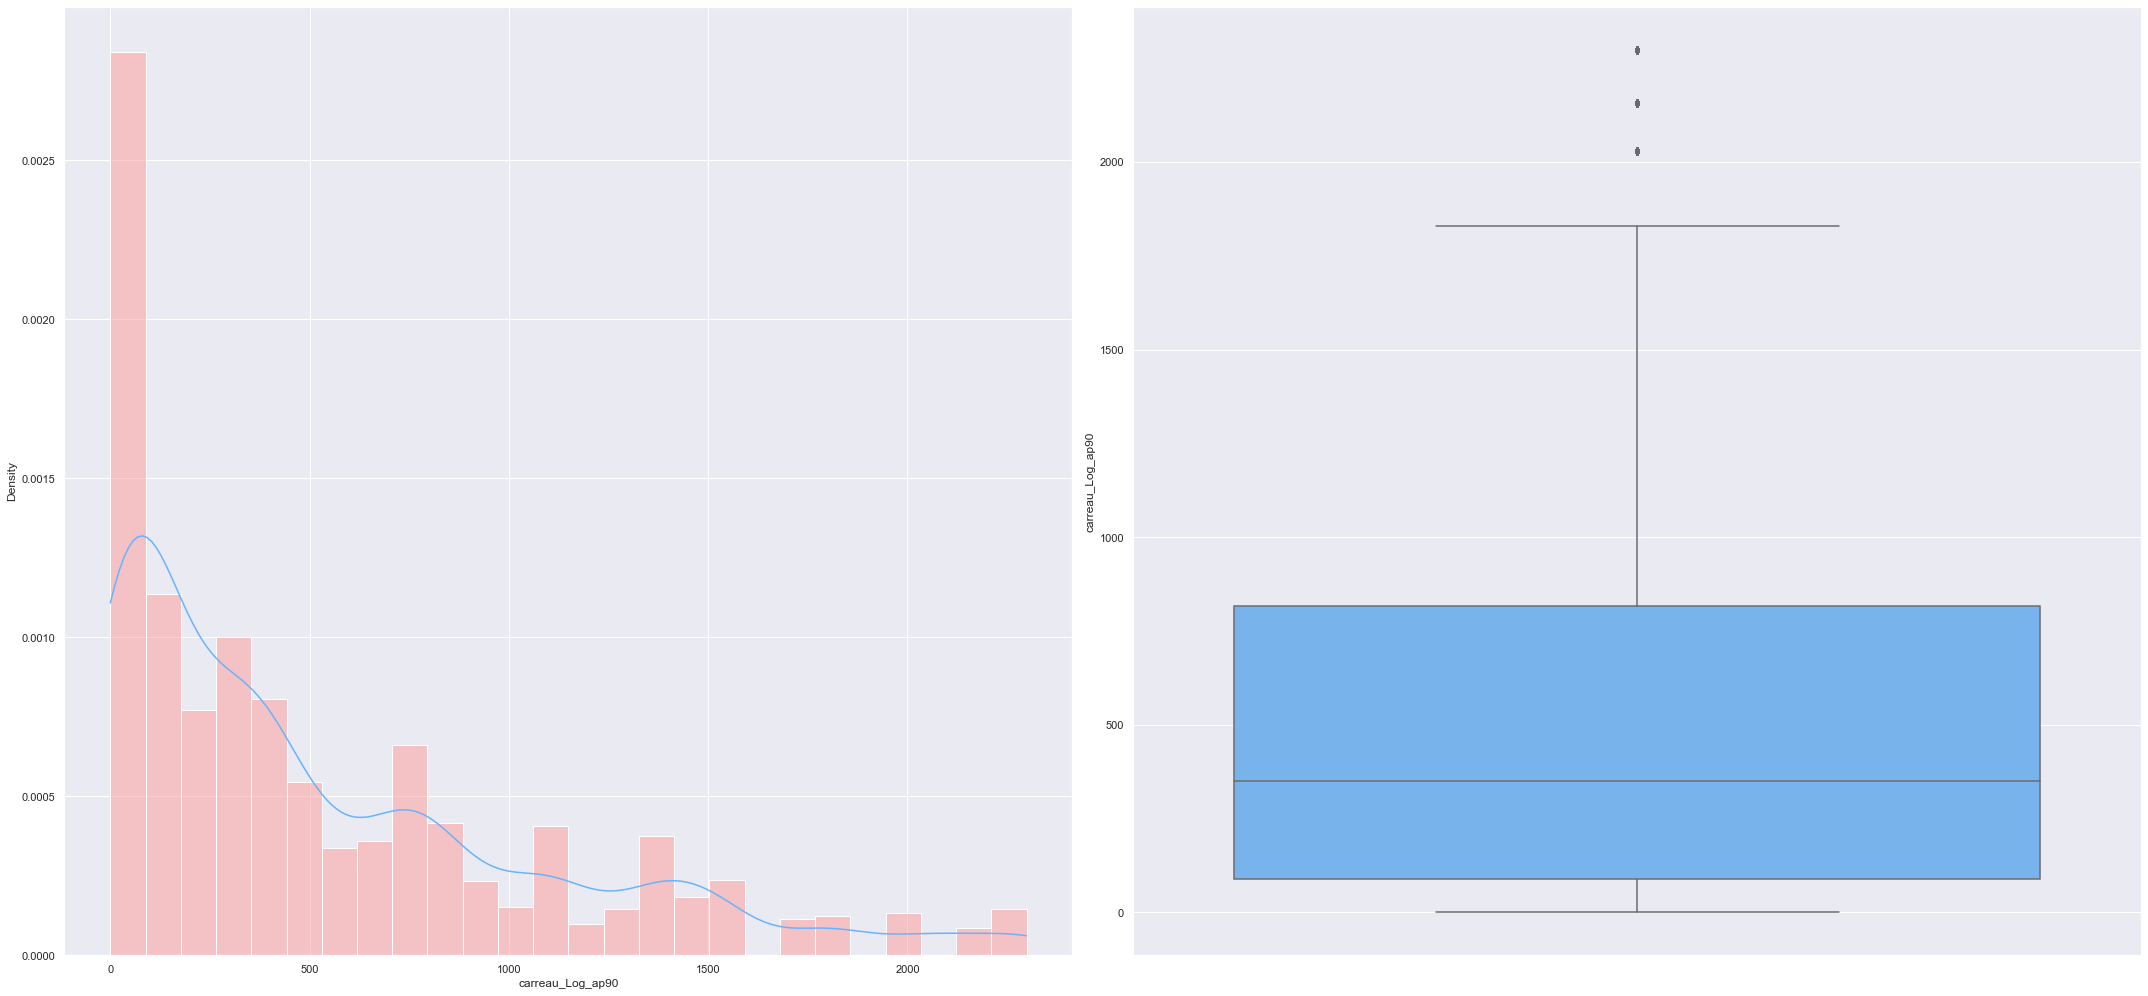

********************************
count    4000.000000
mean      215.454125
std       319.821576
min         0.000000
25%        19.000000
50%        55.000000
75%       234.000000
max      1559.000000
Name: carreau_Log_45_70, dtype: float64


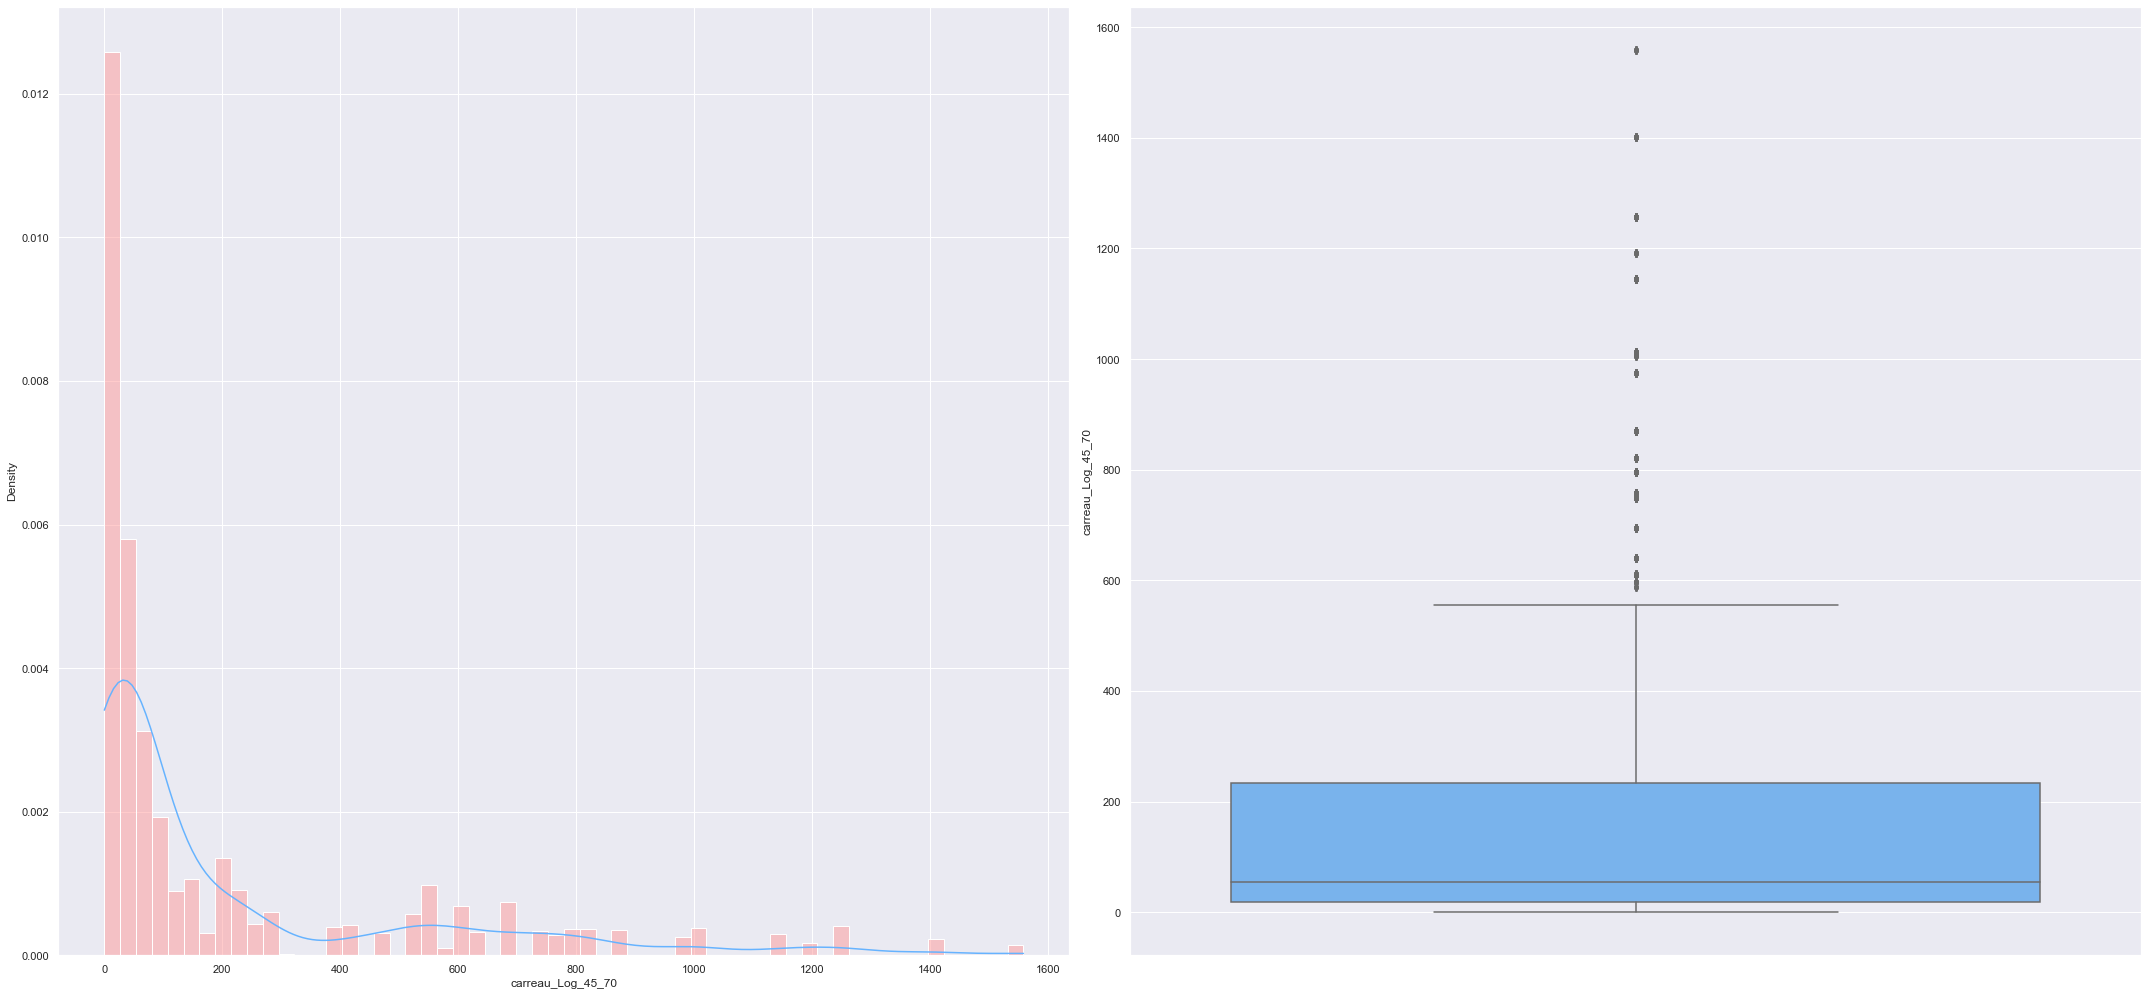

********************************
count    4000.000000
mean       56.775100
std        55.845537
min         0.000000
25%        13.000000
50%        43.000000
75%        85.000000
max       274.000000
Name: carreau_Ind_inc, dtype: float64


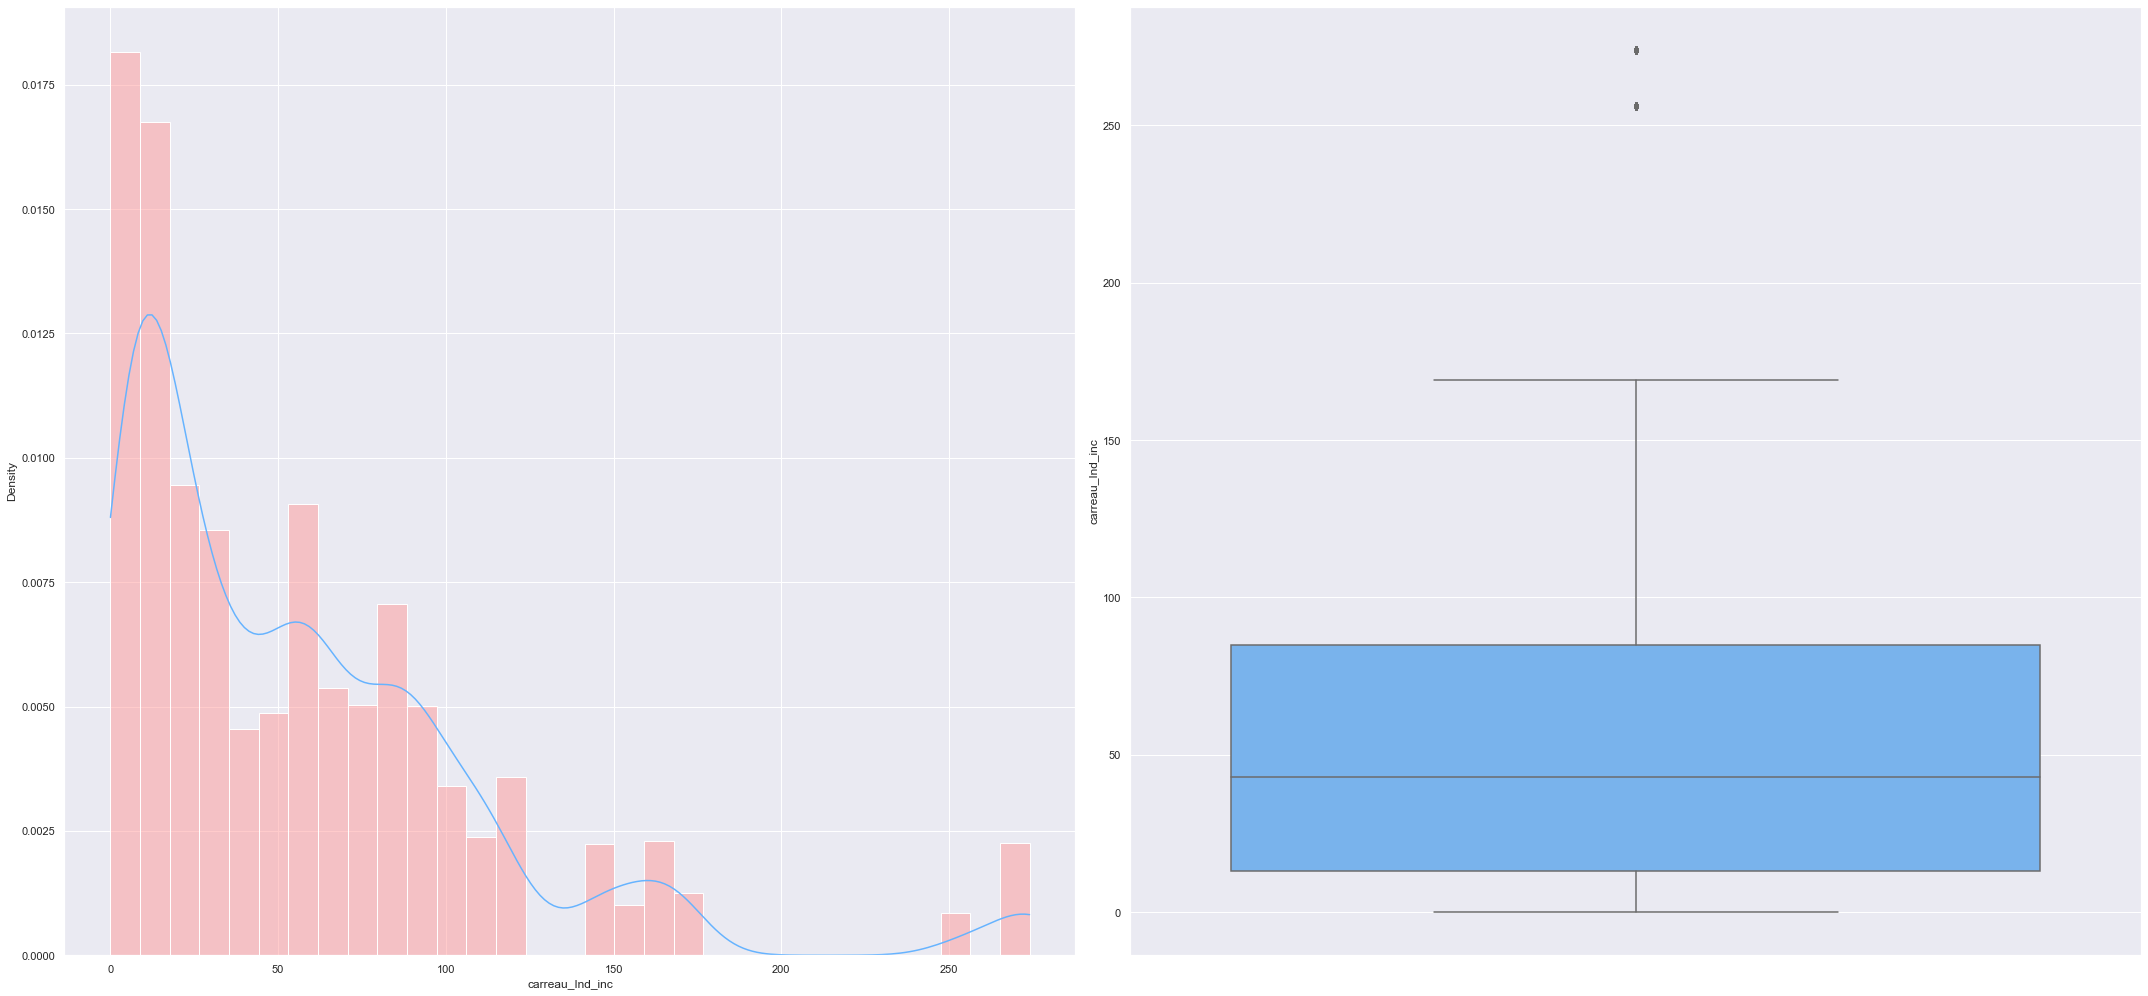

********************************
count    4000.000000
mean      134.545575
std       120.385333
min         0.000000
25%        24.900000
50%       108.600000
75%       217.400000
max       628.000000
Name: carreau_Ind_6_10, dtype: float64


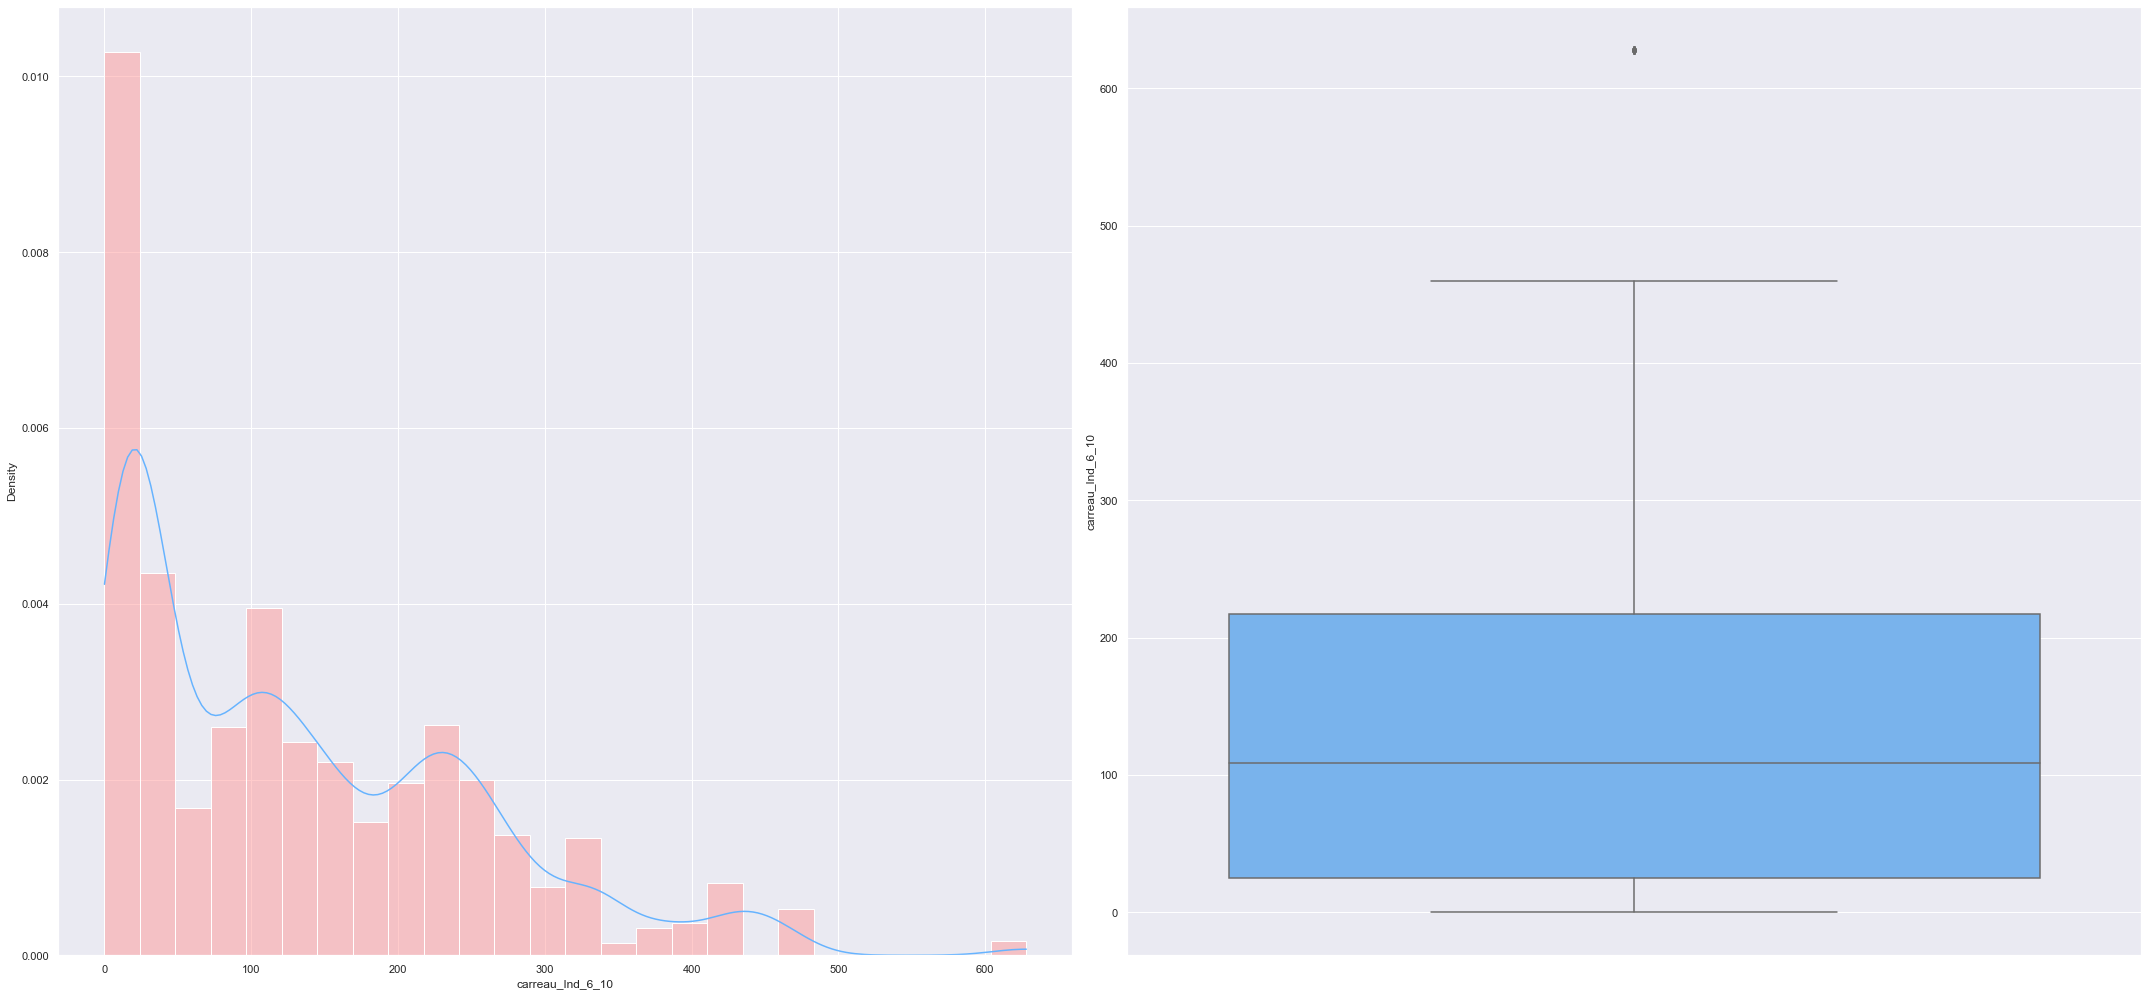

********************************
count    4000.000000
mean      571.907900
std       694.397193
min         2.800000
25%       112.000000
50%       241.000000
75%       903.000000
max      2996.000000
Name: carreau_Men_1ind, dtype: float64


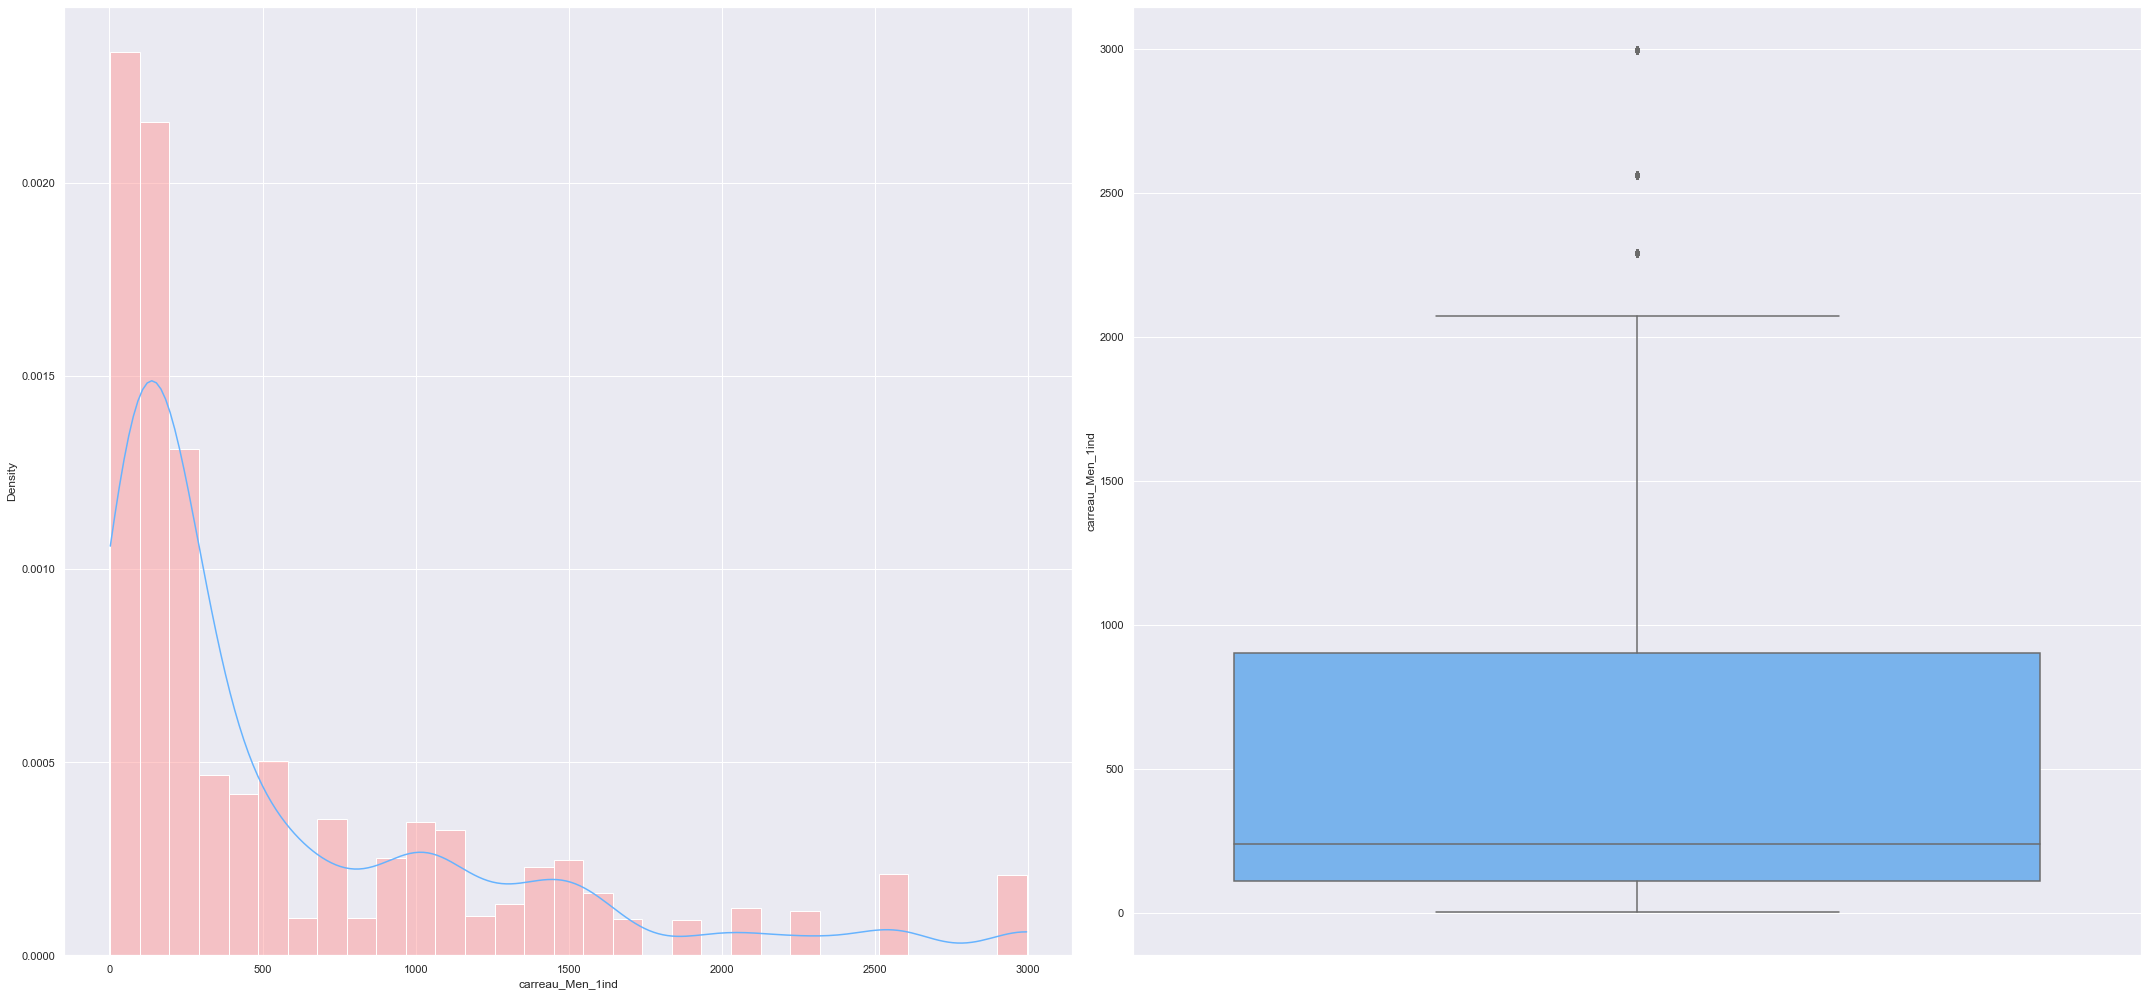

********************************
count    4000.000000
mean      115.476025
std       127.698454
min         0.000000
25%        21.000000
50%        54.000000
75%       195.900000
max       576.000000
Name: carreau_Ind_80p, dtype: float64


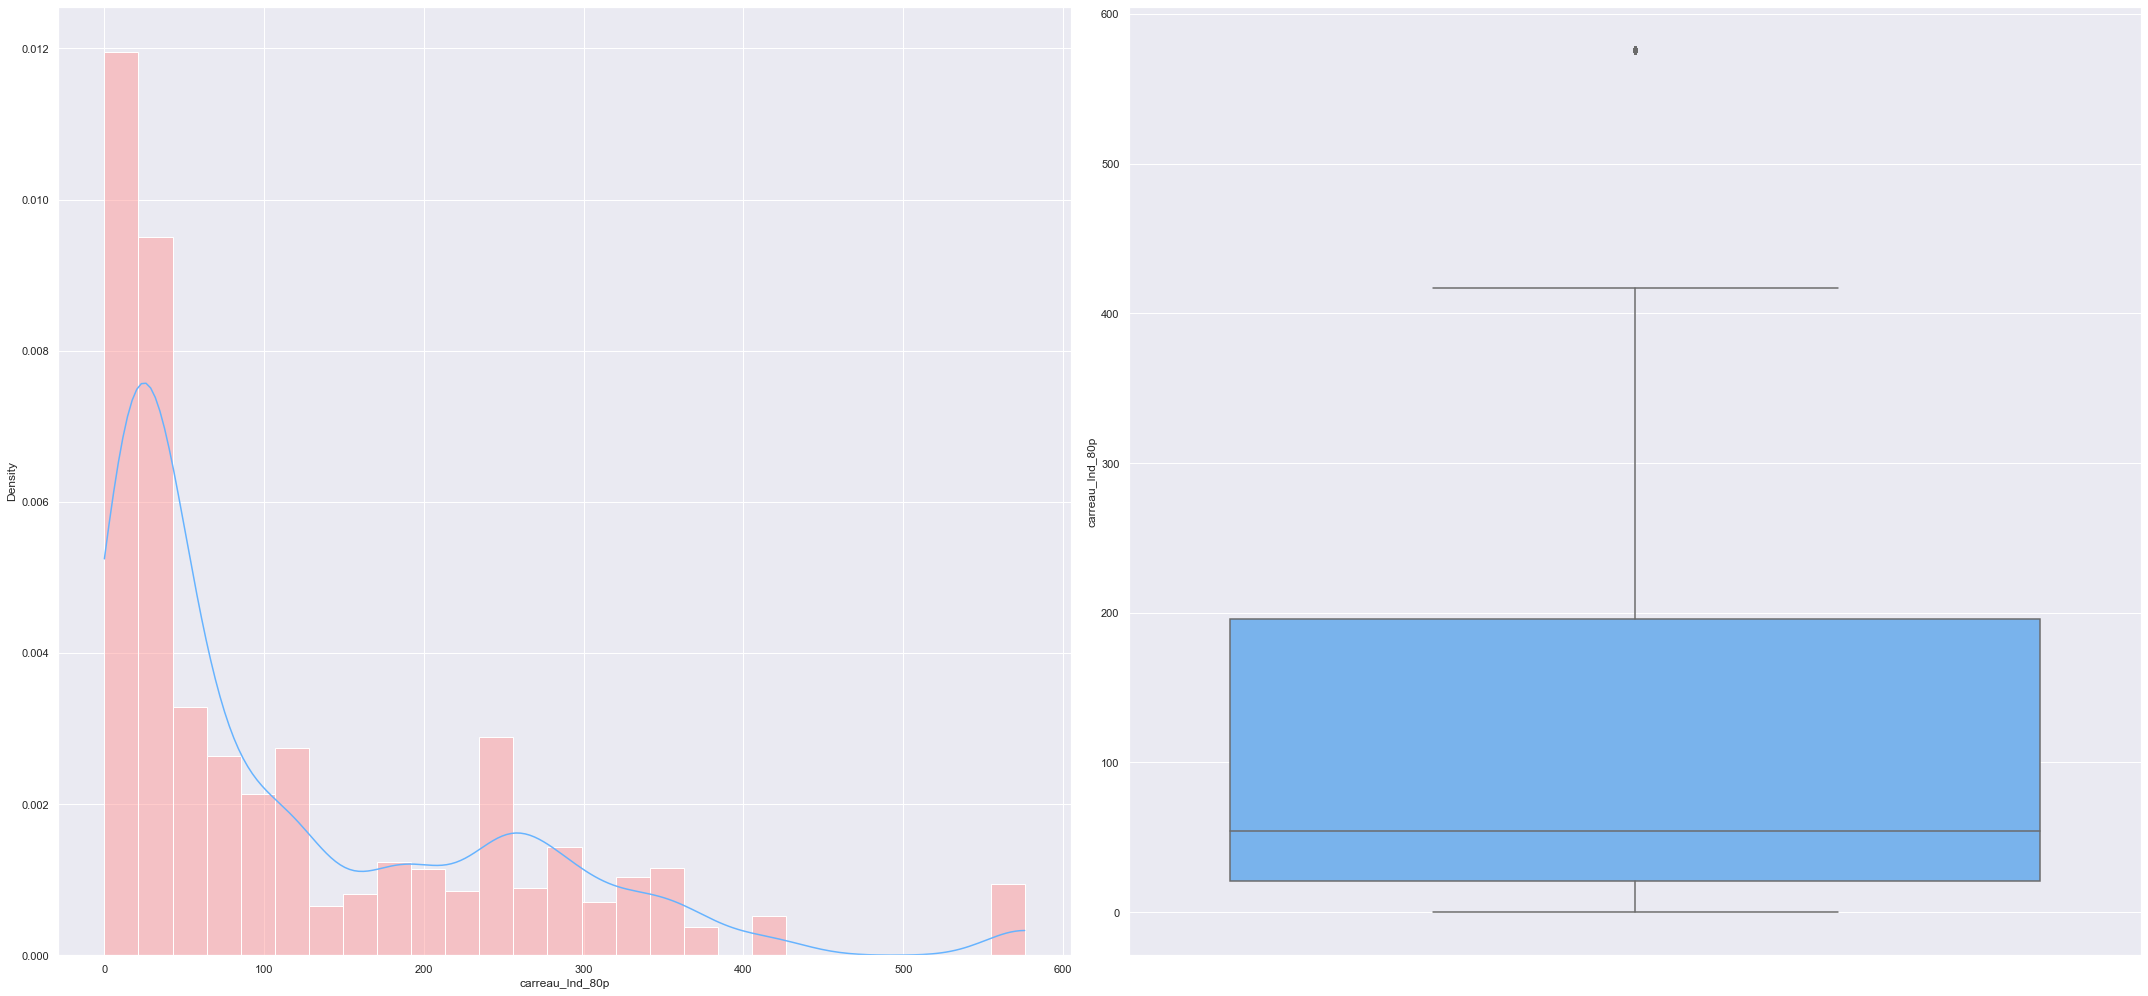

********************************
count    4000.000000
mean      203.443175
std       246.932658
min         0.000000
25%        35.000000
50%        85.900000
75%       291.000000
max      1139.000000
Name: carreau_Men_pauv, dtype: float64


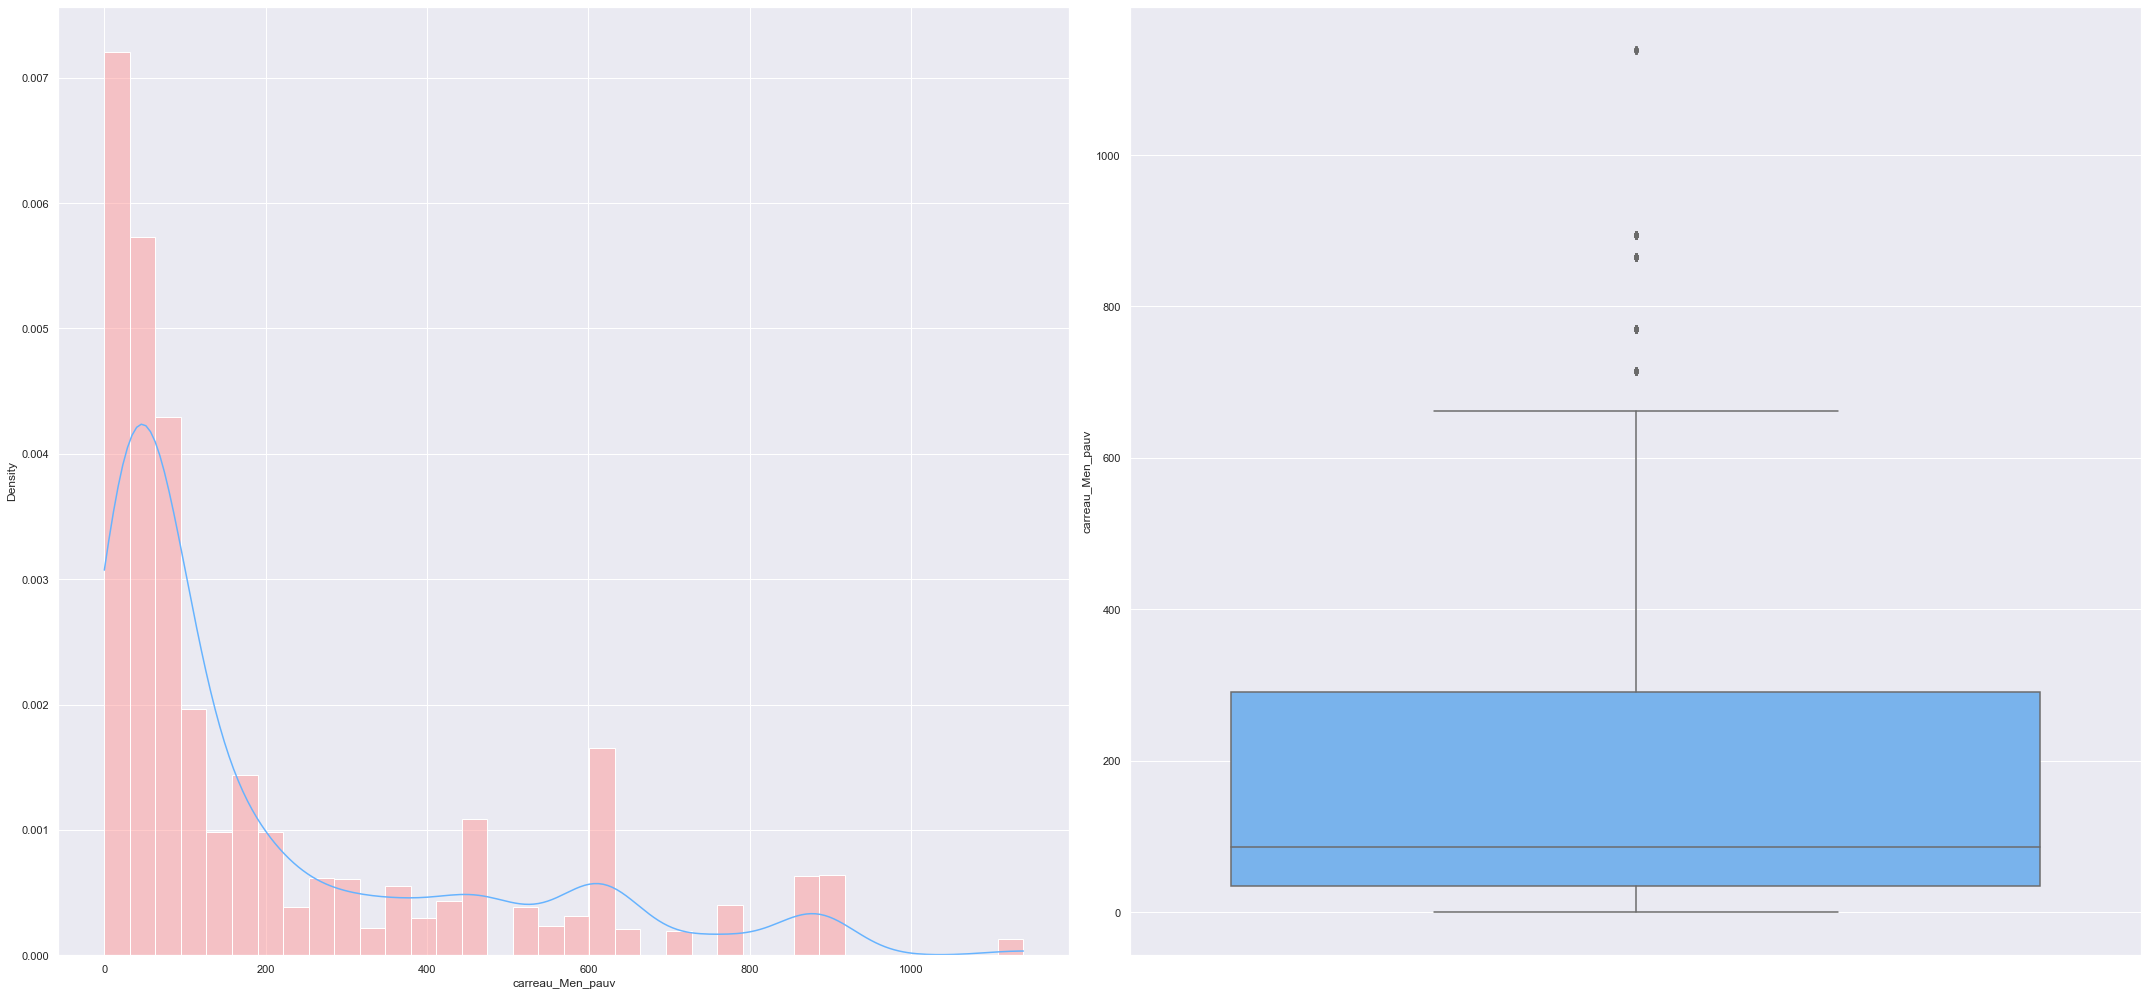

********************************
count    4000.00000
mean      837.80000
std       476.24349
min       200.00000
25%       200.00000
50%      1000.00000
75%      1000.00000
max      4000.00000
Name: carreau_t_maille, dtype: float64


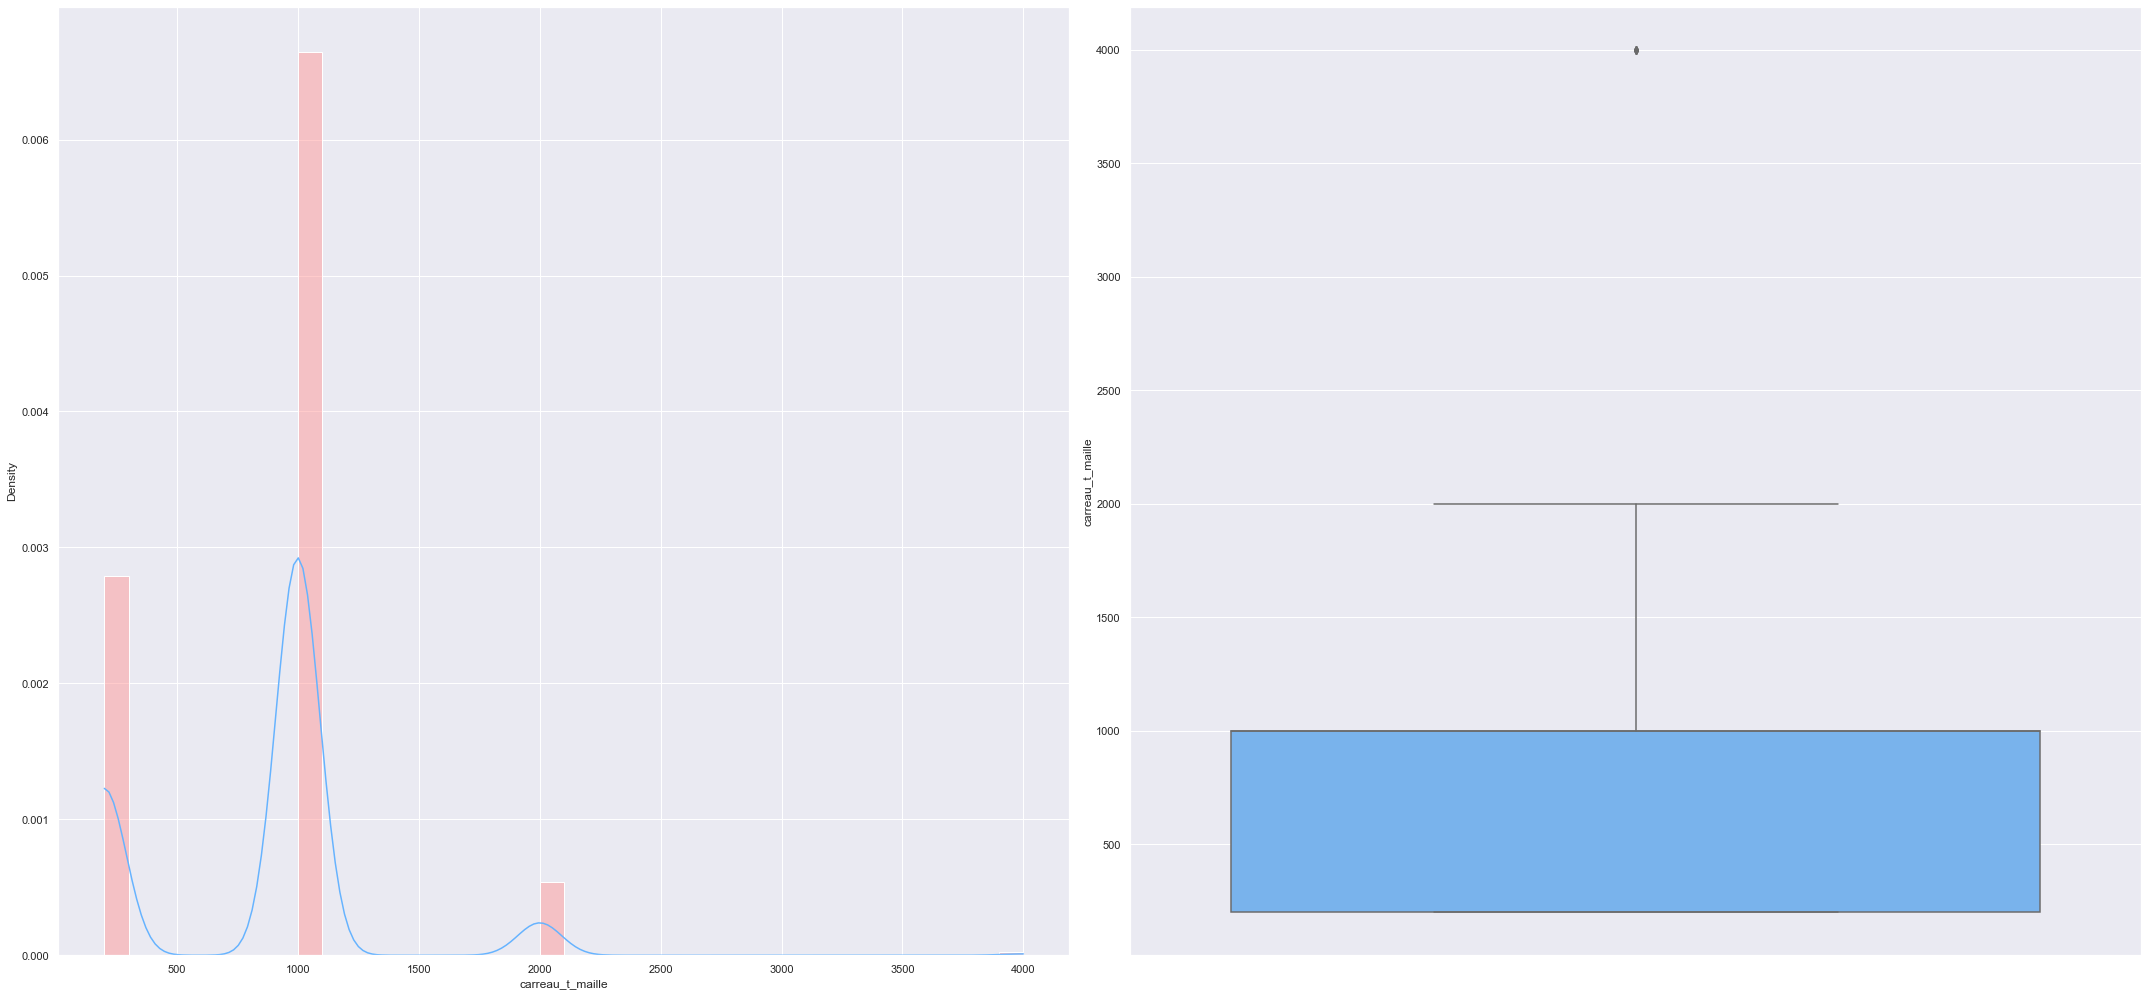

********************************
count     4000.000000
mean     15612.237728
std      11002.005235
min          1.708995
25%        460.114173
50%      23542.431482
75%      23542.431482
max      23542.431482
Name: P16_LOGVAC, dtype: float64


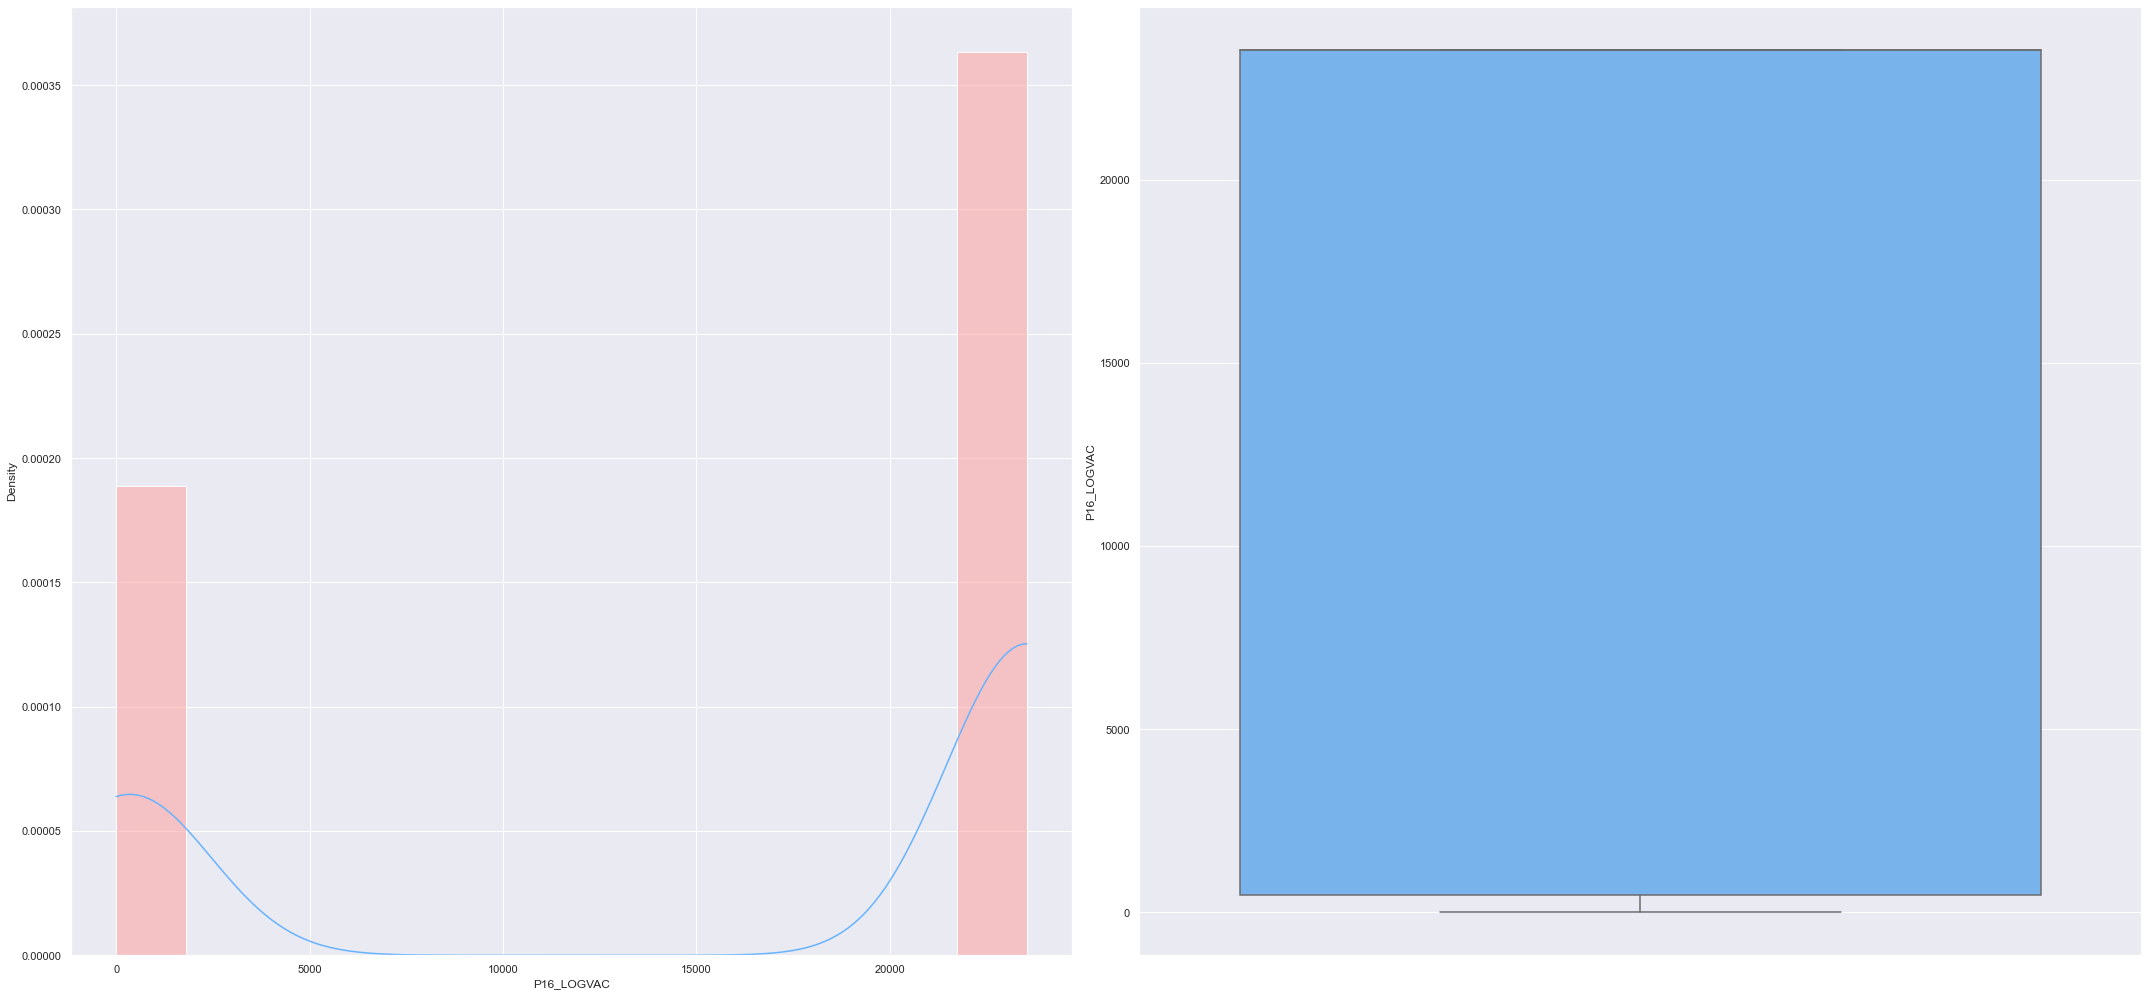

********************************
count    4000.00000
mean       58.14050
std        33.52976
min         1.00000
25%        13.00000
50%        82.00000
75%        82.00000
max        82.00000
Name: ETAZ15, dtype: float64


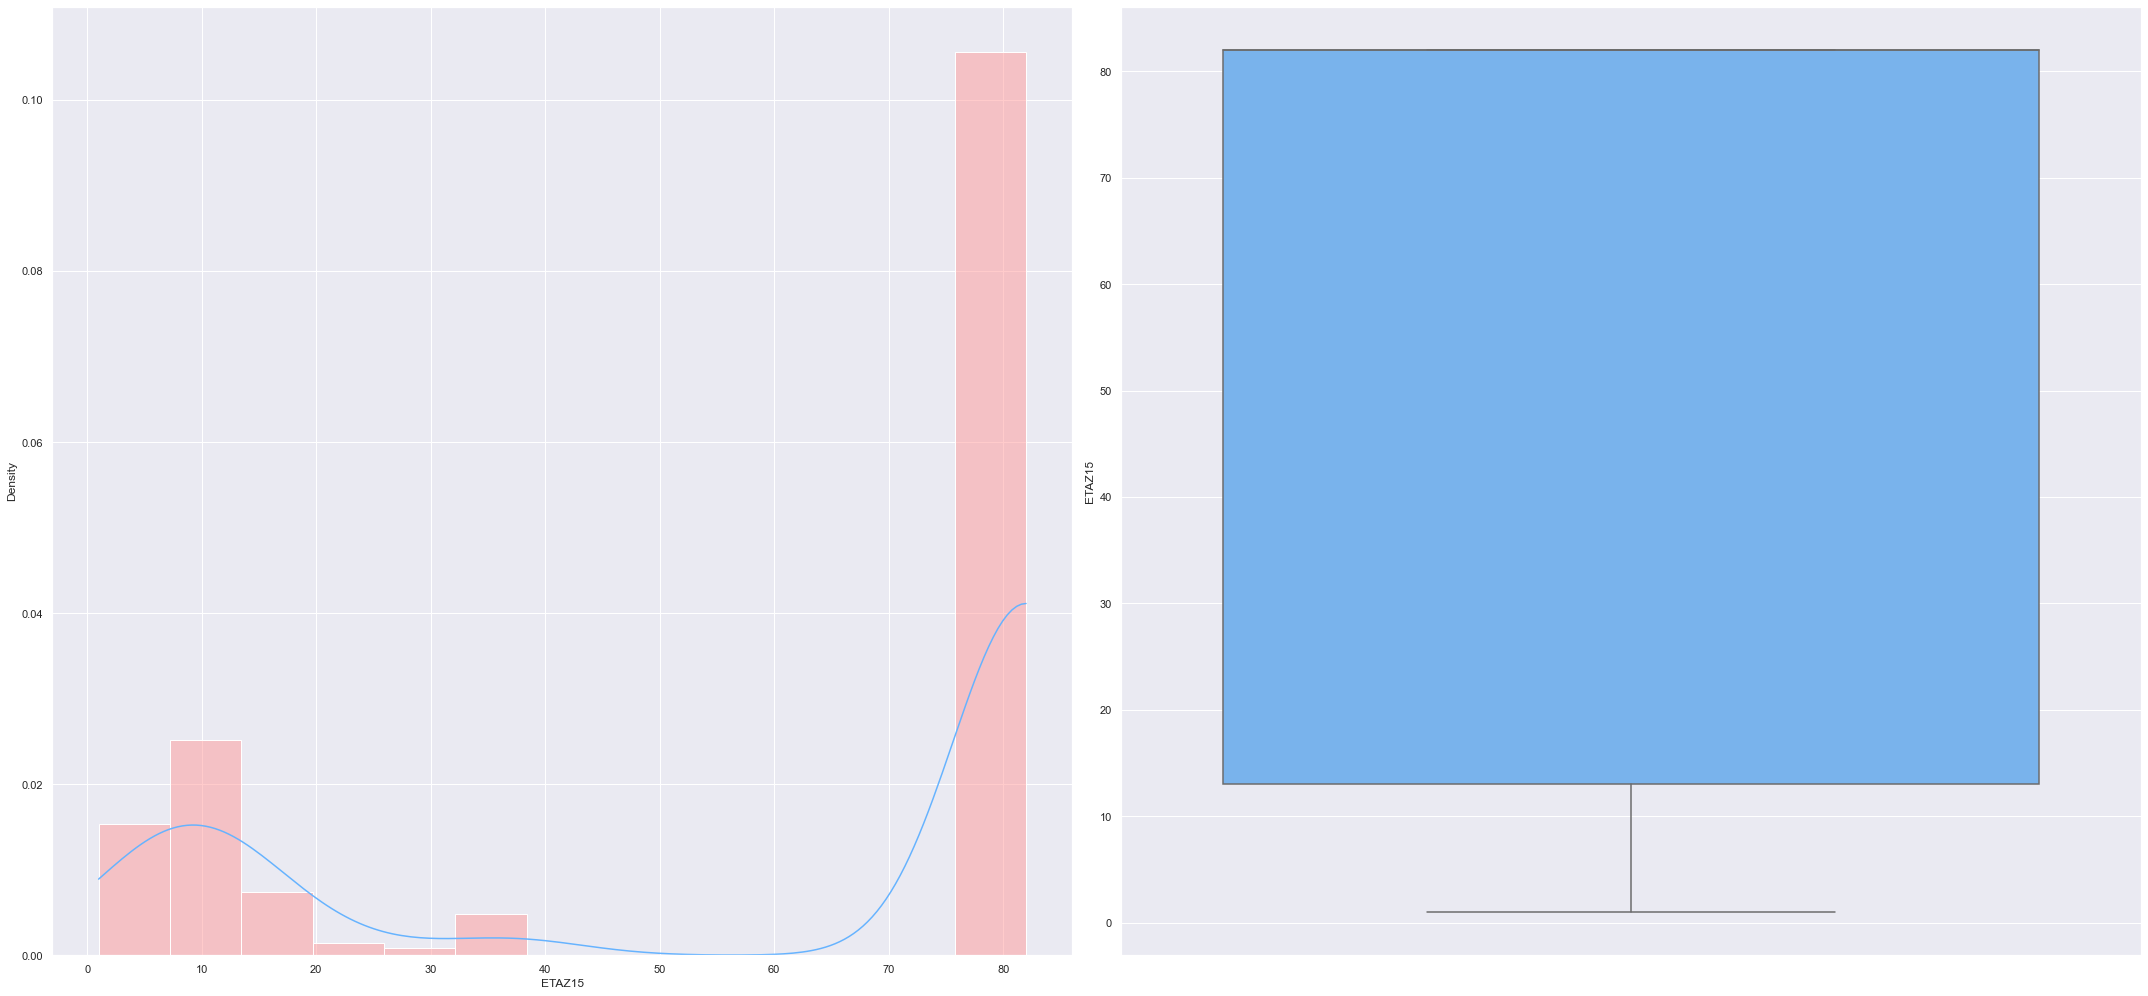

********************************
count    4000.000000
mean      181.009775
std       193.603951
min         0.000000
25%        37.500000
50%       102.900000
75%       255.000000
max       701.500000
Name: carreau_Ind_18_24, dtype: float64


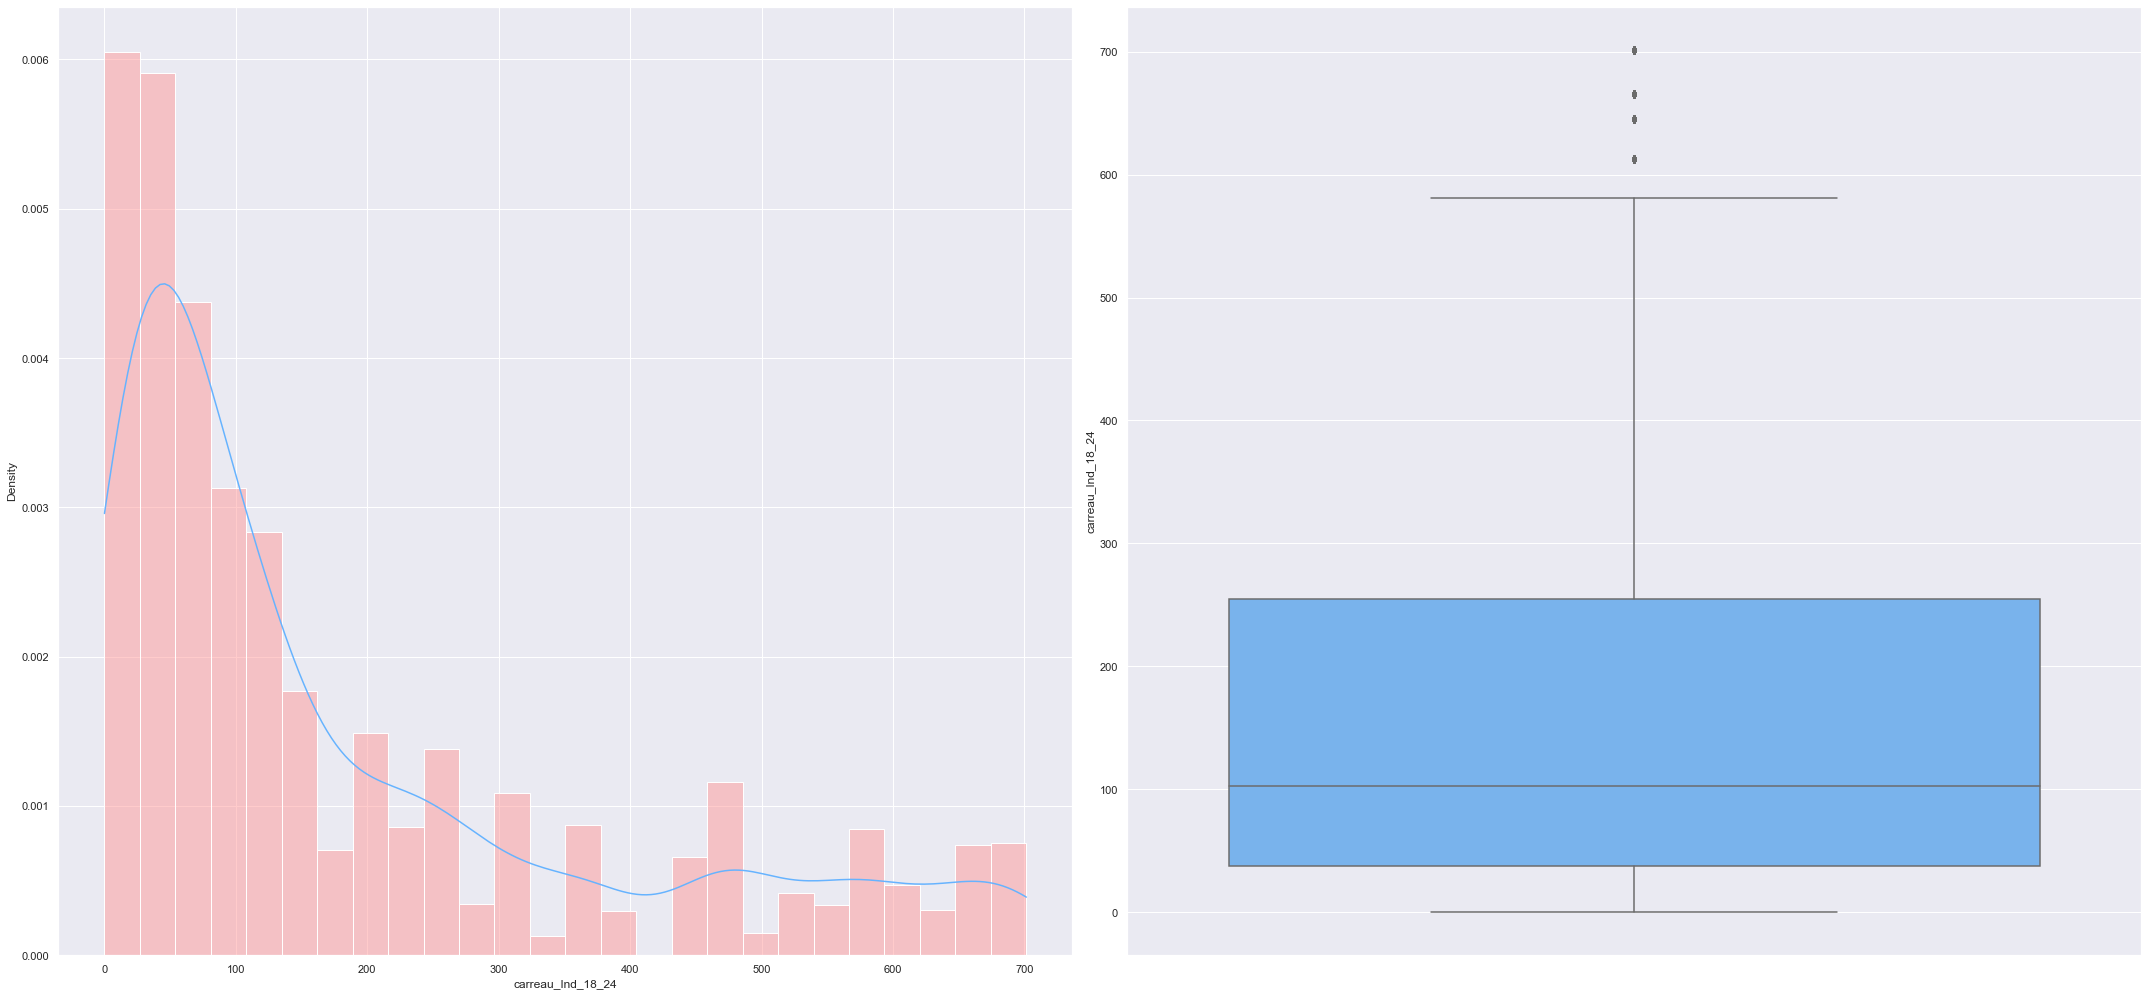

********************************
count     4000.000000
mean     21628.865049
std       2150.847794
min      20250.500000
25%      20430.000000
50%      20430.000000
75%      22700.952381
max      34259.444444
Name: MED16, dtype: float64


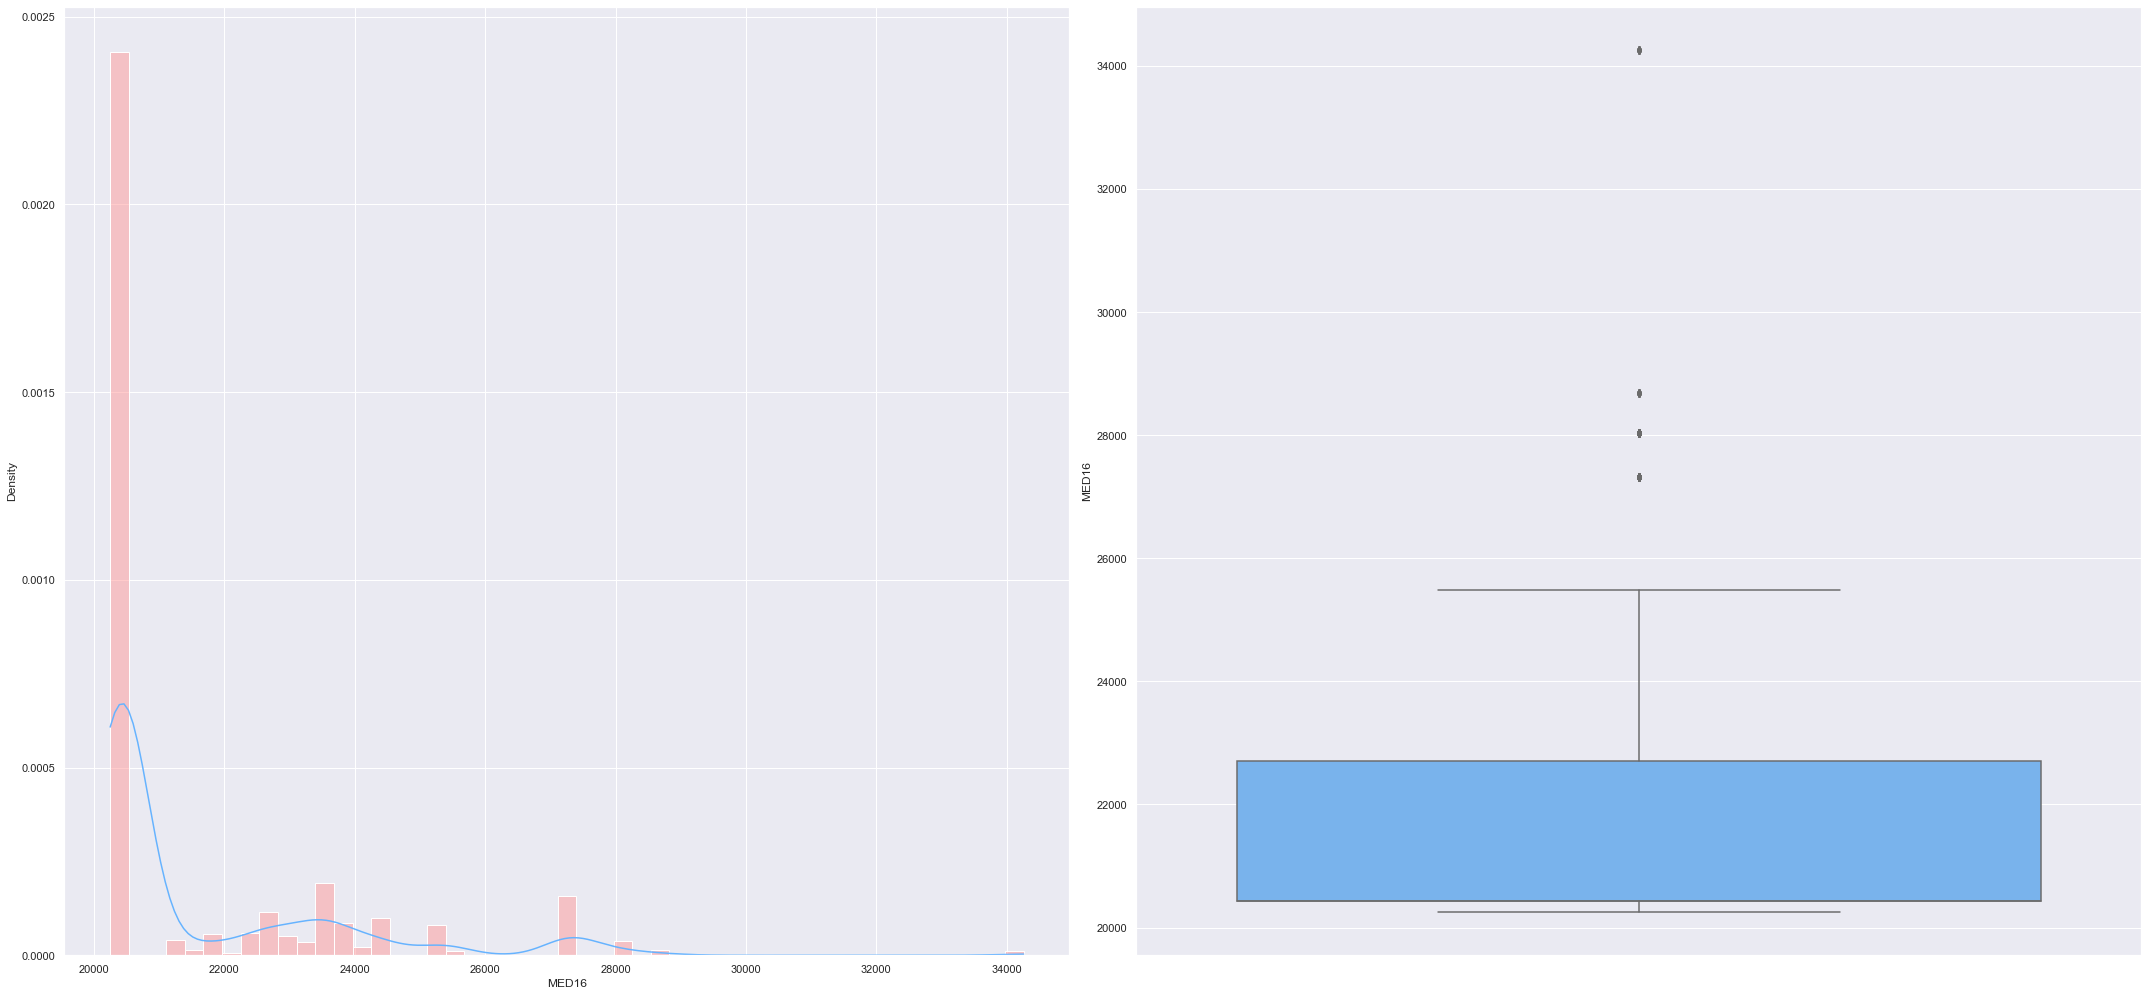

In [671]:
for elt in var_sel:
    #histBox_cust(df_merge_new, variable=var_sel[6], color=0, log=False)
    histBox_cust(df_merge_new, variable=elt, color=0, log=False)

#### IV. Analyse descriptive bivariée

##### IV.1. Variable cible vs prédicteurs quantitatifs de la base agence 

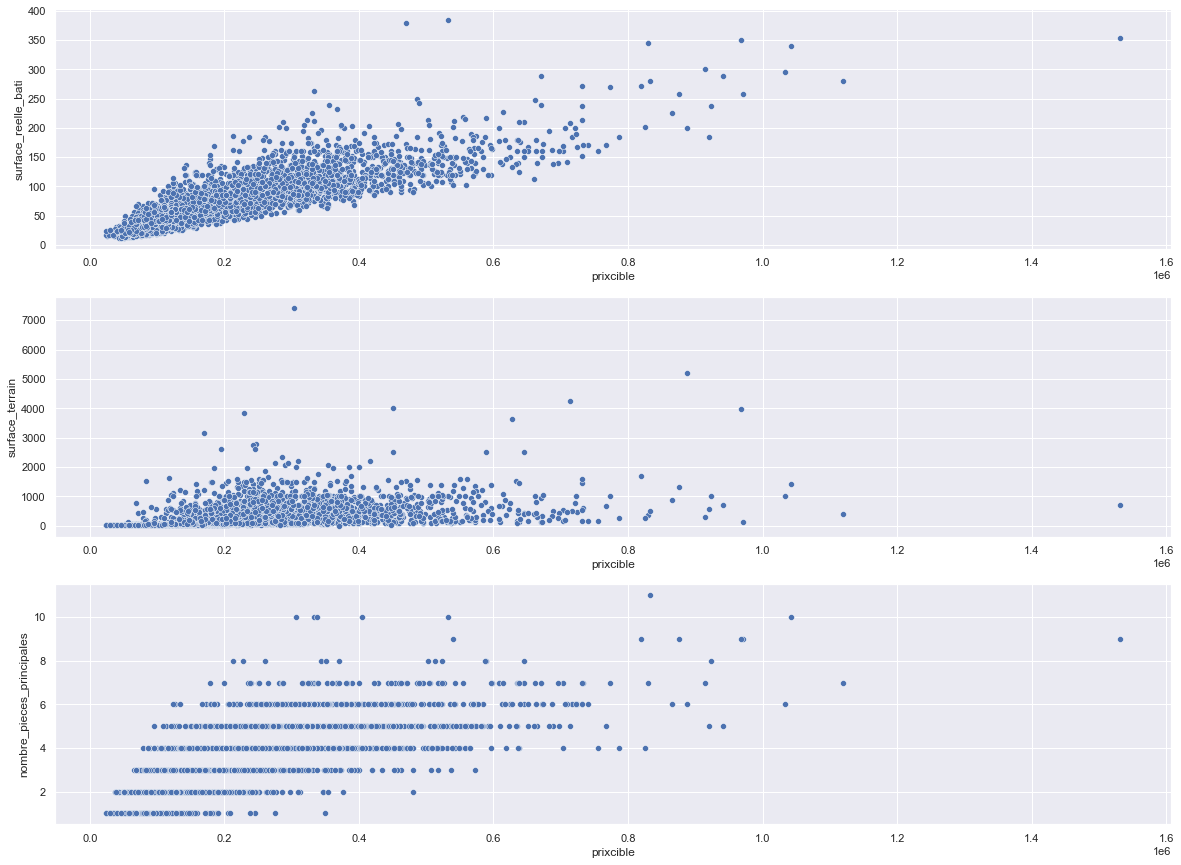

In [672]:
scatter(df_merge_new, x_var='prixcible', y_var=['surface_reelle_bati','surface_terrain','nombre_pieces_principales'], height=15, log=False)

##### IV.2. Variable cible vs prédicteurs quantitatifs de la base agence 

In [673]:
def boxplot_biv(data, var_qual, var_quan):
    fig, axes = plt.subplots(figsize=(20, 6))
    sns.boxplot(ax = axes, data=data, x=var_quan, y=var_qual, palette={'#ff9999','#66b3ff'})

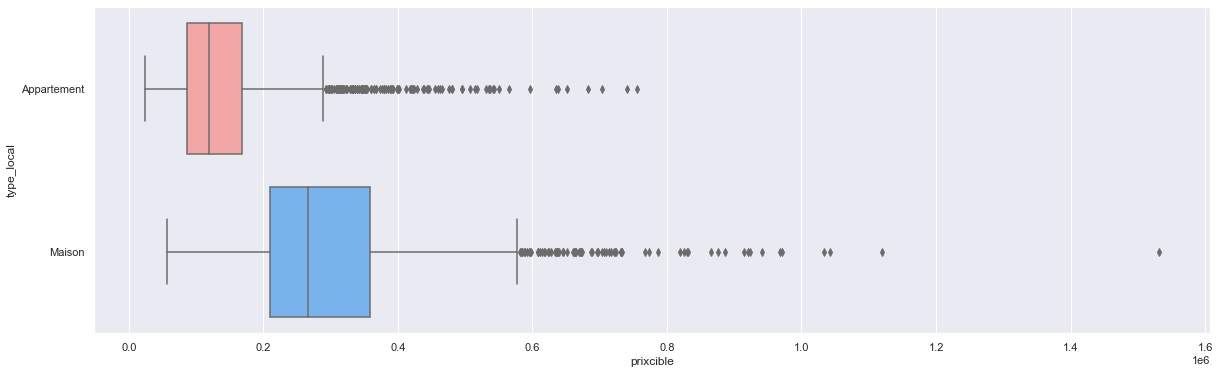

In [674]:
boxplot_biv(df_merge_new, "type_local", "prixcible")

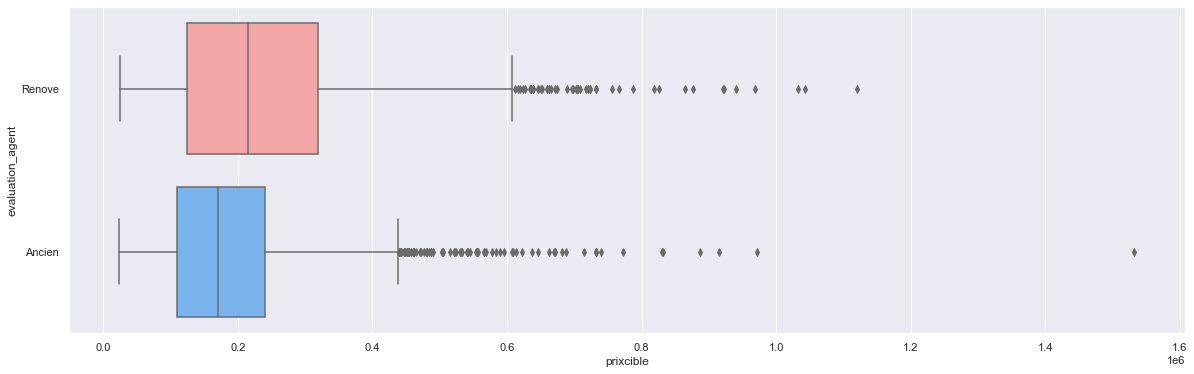

In [675]:
boxplot_biv(df_merge_new, "evaluation_agent", "prixcible")

##### IV.3. Variable cible vs prédicteurs quantitatifs des bases France et Insse 

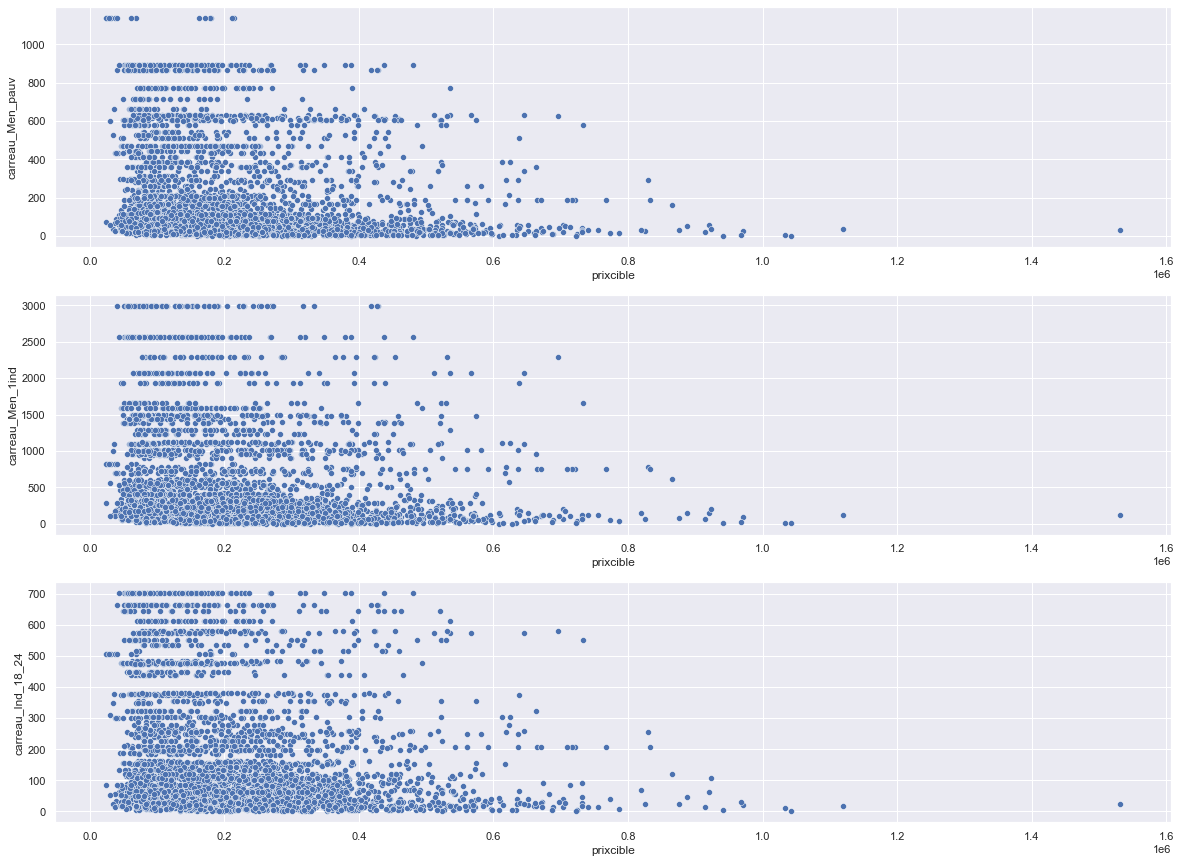

In [676]:
scatter(df_merge_new, x_var='prixcible', y_var=['carreau_Men_pauv','carreau_Men_1ind','carreau_Ind_18_24'], height=15, log=False)

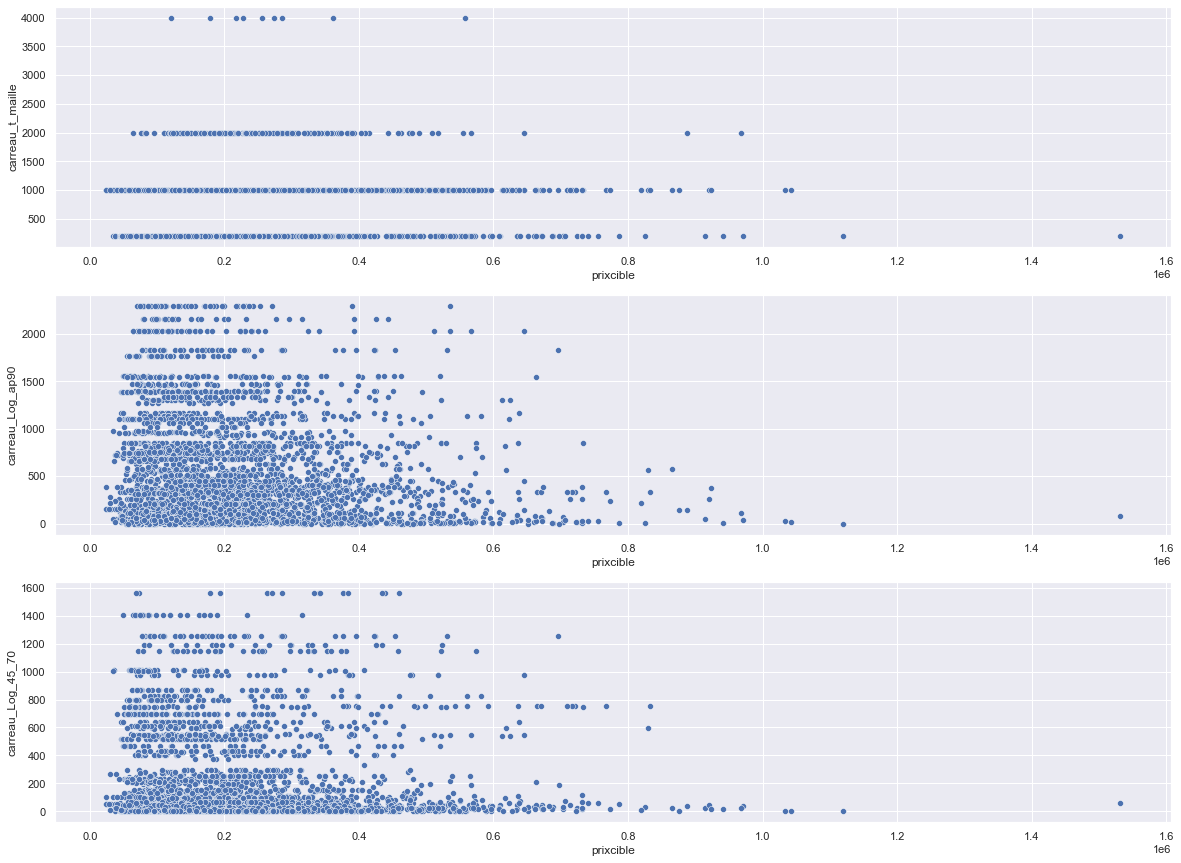

In [677]:
scatter(df_merge_new, x_var='prixcible', y_var=['carreau_t_maille','carreau_Log_ap90','carreau_Log_45_70'], height=15, log=False)

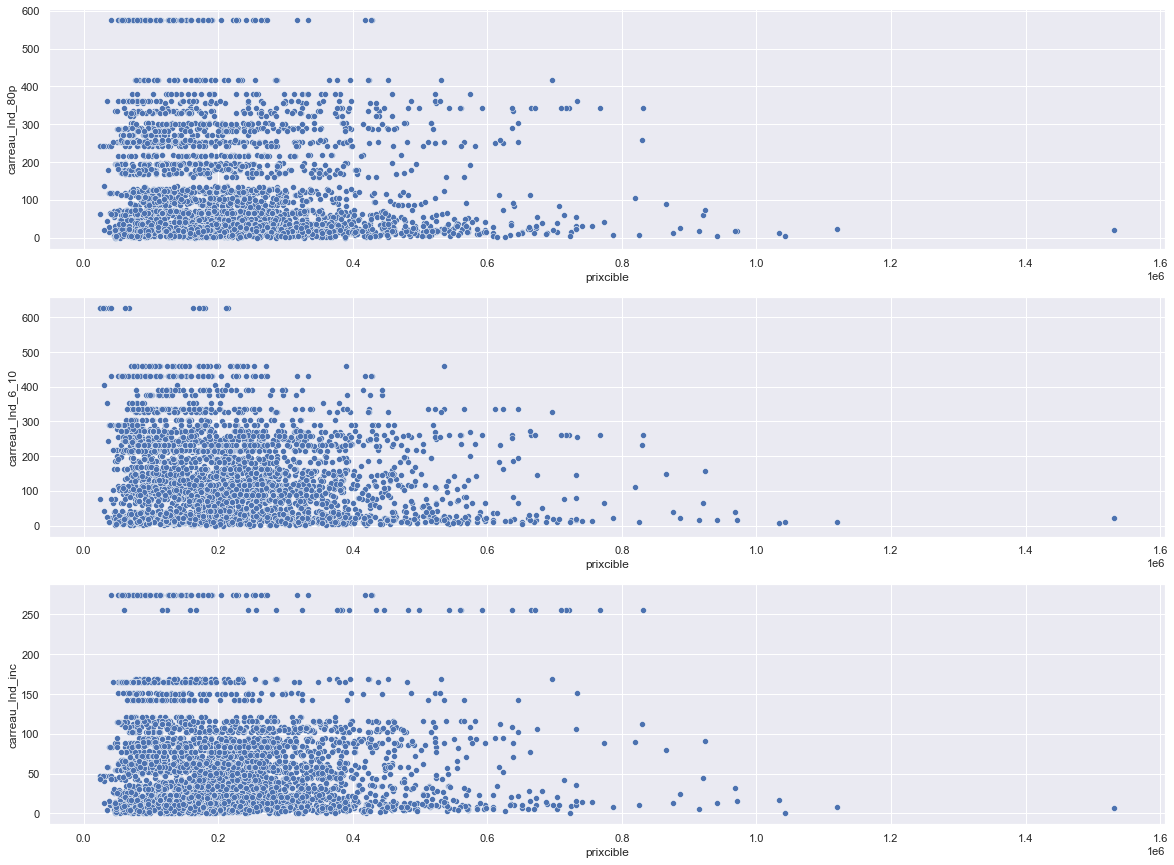

In [678]:
scatter(df_merge_new, x_var='prixcible', y_var=['carreau_Ind_80p','carreau_Ind_6_10','carreau_Ind_inc'], height=15, log=False)

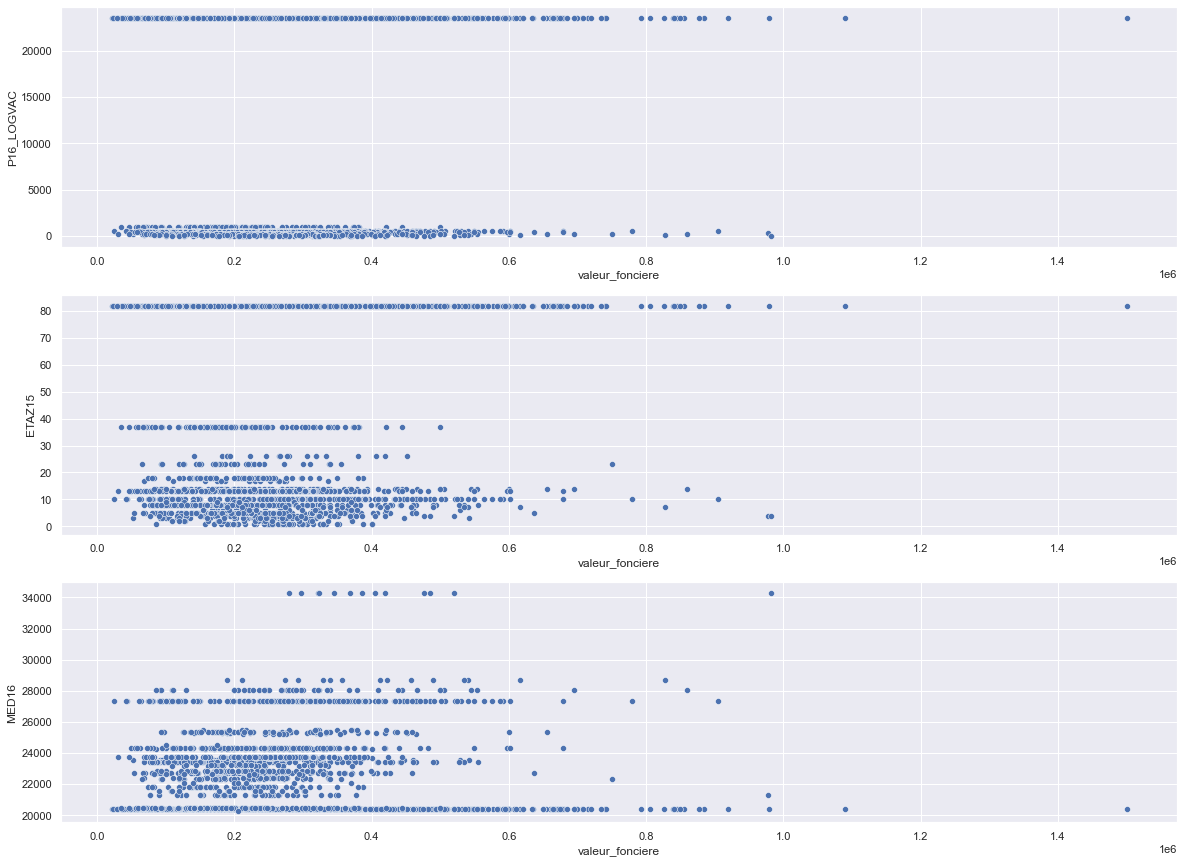

In [679]:
scatter(df_merge_new, x_var='valeur_fonciere', y_var=['P16_LOGVAC','ETAZ15','MED16'], height=15, log=False)

##### IV.4. Matrice de corrélation entre les variables quantiatives de la base df_merge

<AxesSubplot:>

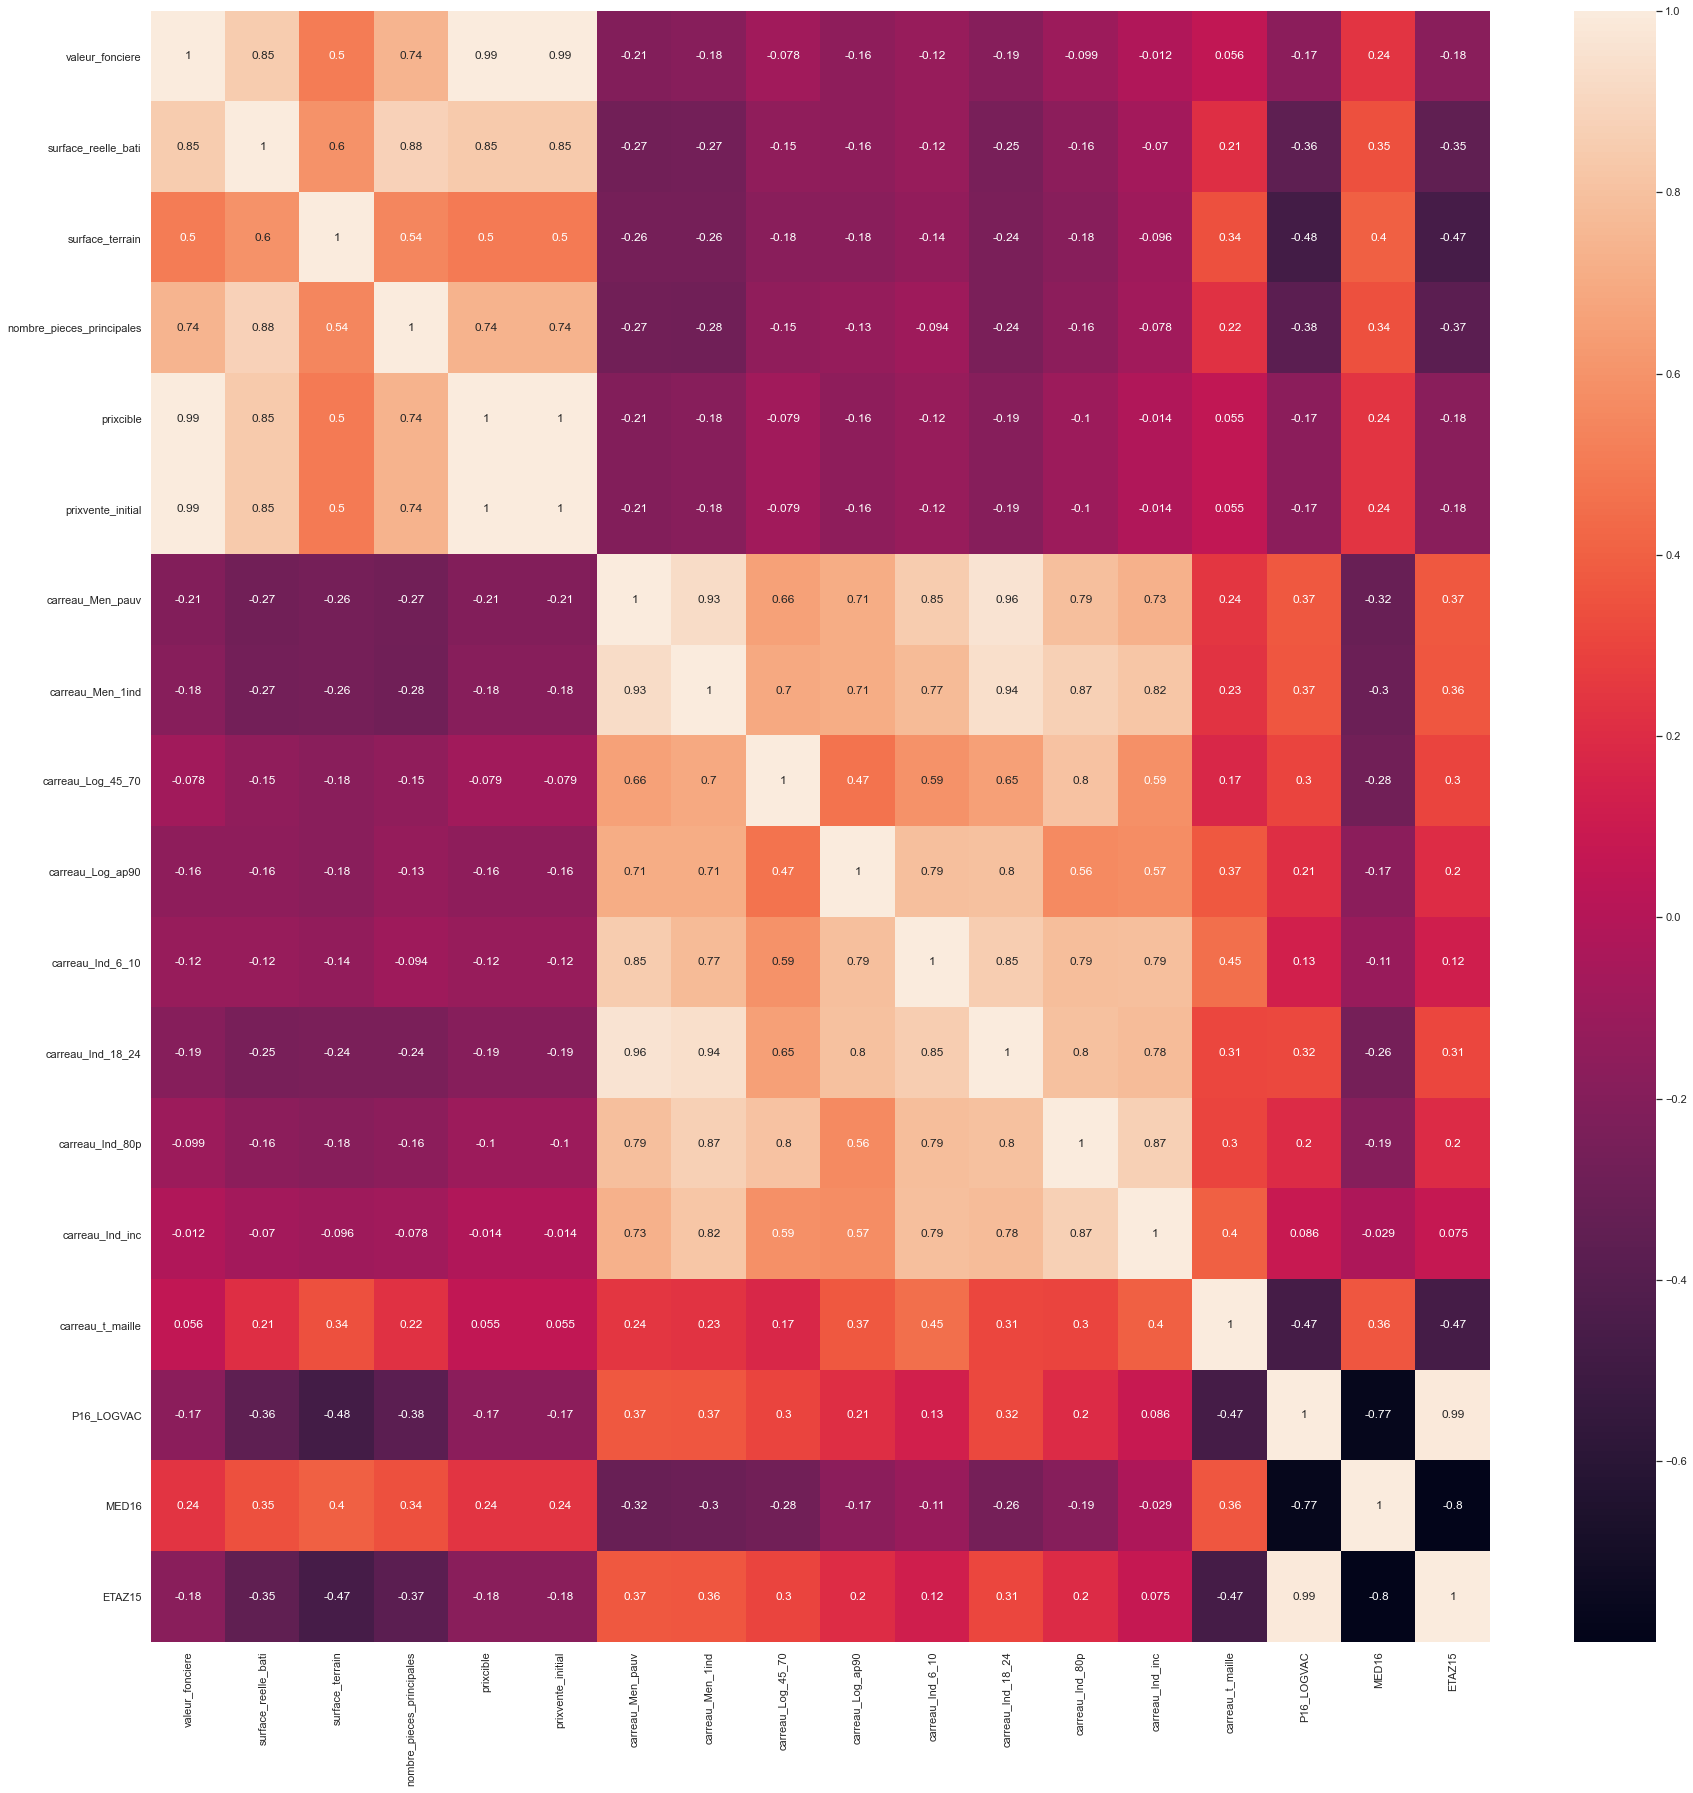

In [680]:
## Tableau de corrélation entre les variables 
var_type=df_merge_new.dtypes.reset_index()
var_type.columns = ['variable', 'type']
var_type['type'] = var_type['type'].astype('str')
var_quan = list(var_type[var_type['type'].isin(['float64', 'int64'])]['variable'])

fig, axes = plt.subplots(figsize=(30, 30))
sns.heatmap(df_merge_new[var_quan].corr(), annot=True)

#### V. Construction des modèles de machine learning

##### V.1. Construction des bases de modélisation 

In [681]:
## Suppression des variables très correlées à la variable cible, du nom de la commune et du code postal 
delete_var = ['nom_commune','code_postal','valeur_fonciere','prixvente_initial']

X_var = list(set(list(df_merge_new.columns)).difference(set(delete_var)))

X= df_merge_new[X_var]

## Création des dummies des prédicteurs qualitatifs
def df_onehot(df):
       onehot_df = pd.DataFrame(index = df.index) 
       var_cat = ['type_local', 'evaluation_agent']
       for var in var_cat:
              onehot_df = onehot(onehot_df,df_merge_new, var)
       return onehot_df


X = pd.concat([df_onehot(X), X], axis=1)
X = X.drop(['evaluation_agent','type_local','prixcible'], axis=1)

y = df_merge_new['prixcible']

## Division de la base en base d'apprentissage et base test
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.3, random_state=12)


In [682]:
X.columns

Index(['type_local_Appartement', 'evaluation_agent_Ancien', 'carreau_Men_pauv',
       'carreau_Log_ap90', 'carreau_t_maille', 'surface_terrain',
       'nombre_pieces_principales', 'carreau_Log_45_70', 'P16_LOGVAC',
       'carreau_Ind_inc', 'carreau_Ind_6_10', 'surface_reelle_bati',
       'carreau_Ind_18_24', 'ETAZ15', 'carreau_Men_1ind', 'carreau_Ind_80p',
       'MED16'],
      dtype='object')

##### V.2. Normalisation et sérialisation des données

In [683]:
scaler_mm_y = MinMaxScaler()
scaler_mm_x = MinMaxScaler()

y_train_s = scaler_mm_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_s = scaler_mm_y.transform(y_test.values.reshape(-1, 1))

y_train_s = y_train_s.reshape(y_train_s.shape[0])
y_test_s = y_test_s.reshape(y_test_s.shape[0])


X_train_s = scaler_mm_x.fit_transform(X_train)
X_test_s = scaler_mm_x.transform(X_test)

In [684]:
## Sérialiser les échantillons
with open('train1.pickle', 'wb') as f1:
    pickle.dump([X_train_s, y_train_s], f1)

with open('test1.pickle', 'wb') as f2:
    pickle.dump([X_test_s, y_test_s], f2)

In [685]:
## Charger les échantillons sérialiser
with open('train1.pickle', 'rb') as f1:
    X_train_s, y_train_s = pickle.load(f1)

with open('test1.pickle', 'rb') as f2:
    X_test_s, y_test_s = pickle.load(f2)

##### V.3. Modèle Extreme Gradient Boosting

In [686]:
## Setting des parametères optimisiables
parameters_1 = {'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2],
                'objective':['reg:squarederror'],
                'max_depth': np.arange(3,9,1),
                'min_child_weight':np.arange(3,9,1),
                'subsample':[i/10.0 for i in np.arange(5,8,1)],
                'n_estimators': range(50,200,50), 
                }

parameters_1 = {'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2, 0.3],
                'objective':['reg:squarederror'],
                'max_depth': range(3,10,2),
                'subsample':[i/10.0 for i in range(1,11,1)],
                'n_estimators': range(50,200,50), 
                }

parameters_xgb = parameters_1

In [687]:
## Cross validation et Modélisation 
start_time = time.time()

eval_set = [(X_train_s, y_train_s), (X_test_s, y_test_s)]

xgb_model =  XGBRegressor(use_label_encoder=False, seed=1)

optXgb = GridSearchCV(xgb_model, parameters_xgb, n_jobs=-1, 
                       cv=5, 
                       scoring='r2',
                       verbose=1, refit=True)

optXgb.fit(X_train_s, y_train_s, early_stopping_rounds=10, eval_metric=["rmse","mae"], eval_set=eval_set, verbose=False)

print(time.time()-start_time)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits
362.0807957649231


In [688]:
## Paramètres optimaux 
optXgb.best_params_

{'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 150,
 'objective': 'reg:squarederror',
 'subsample': 1.0}

In [689]:
## Evaluation du modèle
print("Train : ", str(r2_score_custom(optXgb, X_train_s, y_train_s))+"%", "Test : ", str(r2_score_custom(optXgb, X_test_s, y_test_s))+"%" )

Train :  90.29% Test :  80.92%


Text(0.5, 1.0, 'Xgboost mae')

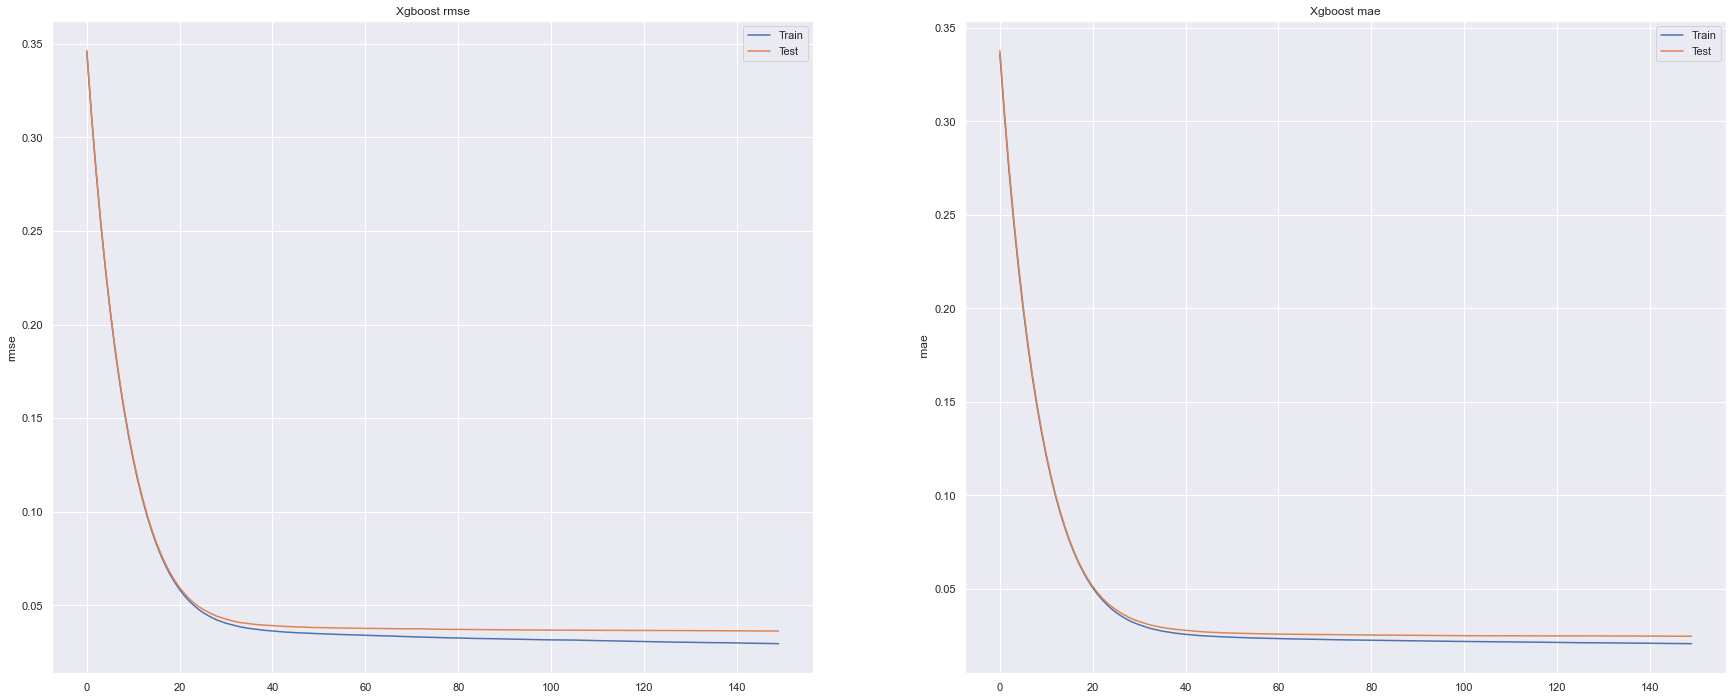

In [690]:
## Construction de la courbe d'apprentissage
results = optXgb.best_estimator_.evals_result()

epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

# rmse
fig, ax = plt.subplots(1,2,figsize=(30, 12))
ax[0].plot(x_axis, results['validation_0']['rmse'], label='Train')
ax[0].plot(x_axis, results['validation_1']['rmse'], label='Test')
ax[0].legend()

ax[0].set_ylabel('rmse')
ax[0].set_title('Xgboost rmse')

# mae
ax[1].plot(x_axis, results['validation_0']['mae'], label='Train')
ax[1].plot(x_axis, results['validation_1']['mae'], label='Test')
ax[1].legend()
ax[1].set_ylabel(' mae')
ax[1].set_title('Xgboost mae')

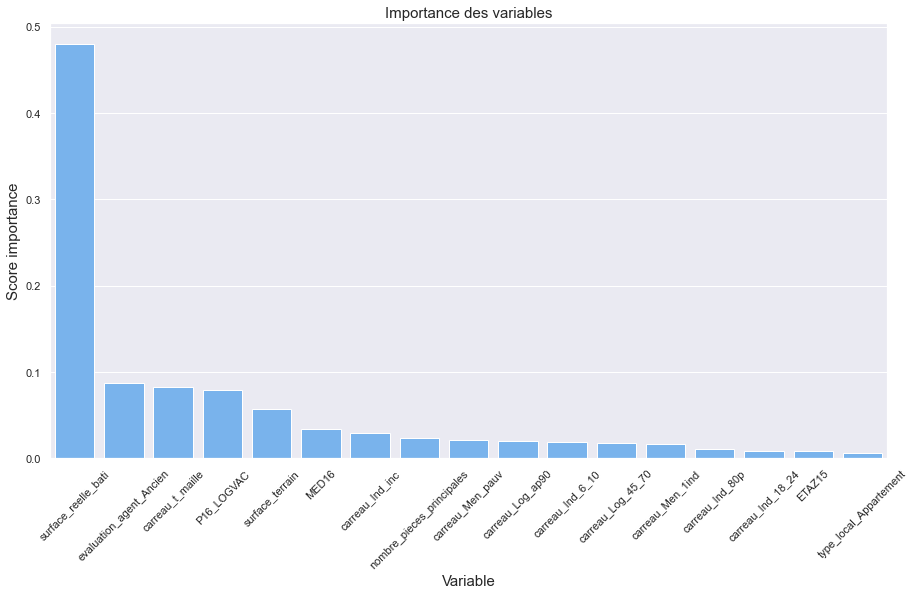

In [691]:
## Importance des variables
feature_importance(optXgb)

##### V.4. Modèle Light Gradient Boosting

In [731]:
## Setting des parametères optimisiables
rng = np.random.default_rng(36)

nb = 15

parameters_lgb ={'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2,0.3,0.4,0.5],
                'num_leaves': rng.choice(range(6,50),nb,replace=False), 
                'min_child_samples': rng.choice(range(100,500),4,replace=False), 
                'max_depth': rng.choice(range(2,20),4,replace=False),
                'subsample': rng.choice(np.arange(0.1,1.0,0.1),4, replace=False),
                'n_estimators': rng.choice(range(100,200),4,replace=False)
                }

In [732]:
## Cross validation et modélisation
start_time = time.time()

eval_set_=[(X_train_s, y_train_s), (X_test_s, y_test_s)]

lgb_model = LGBMRegressor(random_state=314, verbose=-1, metric='None', n_jobs=-1, force_row_wise=True) 

optLgb = RandomizedSearchCV(
    estimator=lgb_model, 
    param_distributions=parameters_lgb, 
    scoring='r2',
    cv=5,
    refit=True,
    random_state=314,
    verbose=True)  
                    

optLgb.fit(X_train_s, y_train_s ,  eval_set=eval_set_, eval_metric=["rmse", "mae"], callbacks=[early_stopping(100)])

print(time.time()-start_time)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[199]	valid_0's rmse: 0.0408657	valid_0's l1: 0.024418	valid_1's rmse: 0.0382396	valid_1's l1: 0.026322
Did not meet early stopping. Best iteration is:
[199]	valid_0's rmse: 0.0397578	valid_0's l1: 0.0241685	valid_1's rmse: 0.0384832	valid_1's l1: 0.0265421
Did not meet early stopping. Best iteration is:
[199]	valid_0's rmse: 0.0397578	valid_0's l1: 0.0241685	valid_1's rmse: 0.0384832	valid_1's l1: 0.0265421
Did not meet early stopping. Best iteration is:
[199]	valid_0's rmse: 0.0397578	valid_0's l1: 0.0241685	valid_1's rmse: 0.0384832	valid_1's l1: 0.0265421
Did not meet early stopping. Best iteration is:
[199]	valid_0's rmse: 0.0397578	valid_0's l1: 0.0241685	valid_1's rmse: 0.0384832	valid_1's l1: 0.0265421
Did not meet early stopping. Best iteration is:
[199]	valid_0's rmse: 0.0397578	valid_0's l1: 0.0241685	valid

In [694]:
## Paramètres optimaux
optLgb.best_params_

{'subsample': 0.4,
 'num_leaves': 42,
 'n_estimators': 199,
 'min_child_samples': 211,
 'max_depth': 15,
 'learning_rate': 0.1}

In [733]:
## Evaluation du modèle
print("Train :", str(r2_score_custom(optLgb, X_train_s, y_train_s))+"%", "Test : ", str(r2_score_custom(optLgb, X_test_s, y_test_s))+"%" )

Train : 83.96% Test :  79.2%


Text(0.5, 1.0, 'Lightgbm Classification Error')

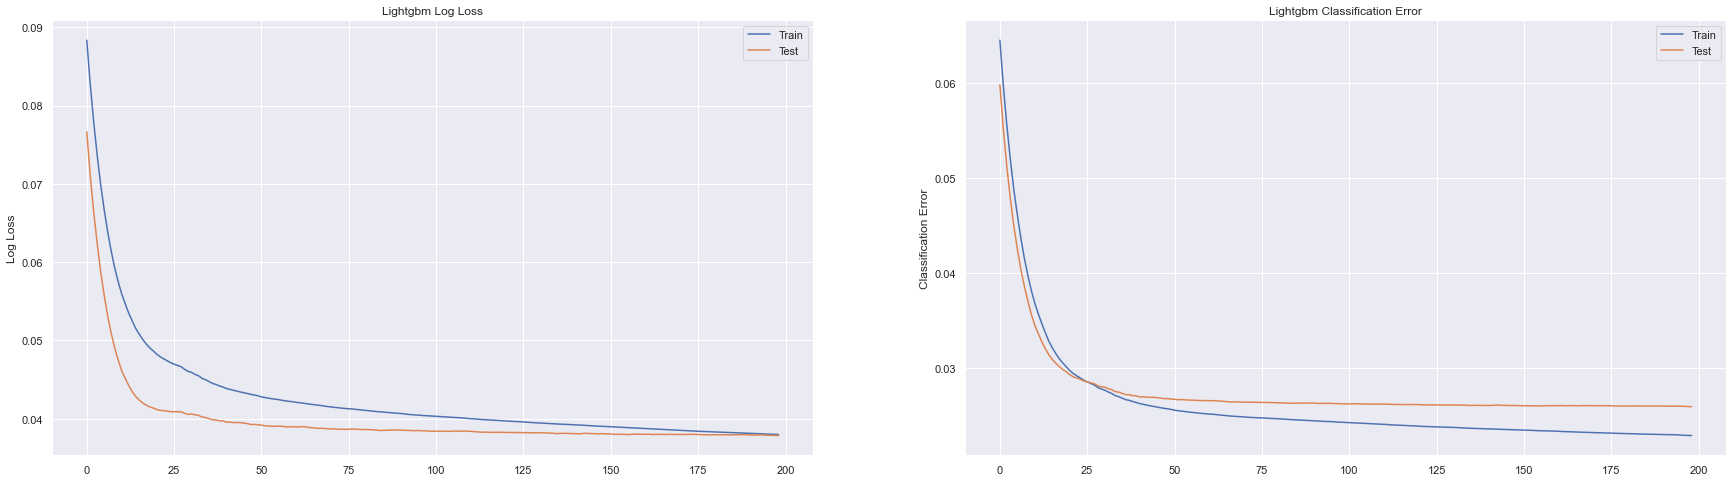

In [696]:
## Construction de la courbe d'apprentissage
results = optLgb.best_estimator_.evals_result_

epochs = len(results['training']['rmse'])

x_axis = range(0, epochs)

## rmse
fig, ax = plt.subplots(1,2,figsize=(30, 8))
ax[0].plot(x_axis, results['training']['rmse'], label='Train')
ax[0].plot(x_axis, results['valid_1']['rmse'], label='Test')
ax[0].legend()

ax[0].set_ylabel('Log Loss')
ax[0].set_title('Lightgbm Log Loss')

## mae
ax[1].plot(x_axis, results['training']['l1'], label='Train')
ax[1].plot(x_axis, results['valid_1']['l1'], label='Test')
ax[1].legend()
ax[1].set_ylabel('Classification Error')
ax[1].set_title('Lightgbm Classification Error')

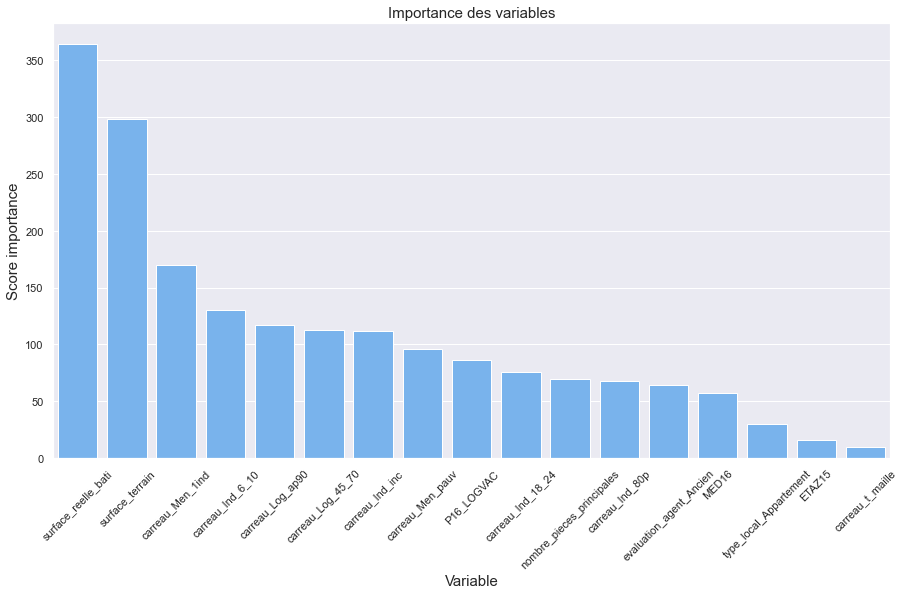

In [697]:
## Importance des variables  
importance_df = pd.DataFrame({
    'Variable': X.columns,
    'Importance': optLgb.best_estimator_.feature_importances_
}).sort_values('Importance', ascending=False)

barplot_cust(importance_df, x_var="Variable", y_var="Importance", title="Importance des variables", lab=False, label_y='Score importance')


##### V.5. Modèle Random Forest

In [698]:
## Setting des paramètres optimisables
parameters_rf = {
    'max_depth': [10,15,20],
    'max_features': [2, 3, 4, 5,6 ],
    'n_estimators': [100, 150, 200, 300],
    'min_samples_leaf':[3, 5,10,15]
}               

In [699]:
## Exécution de la forêt aléatoire
start_time = time.time()

rf_model = RandomForestRegressor(random_state=42,)

optRf = GridSearchCV(rf_model, parameters_rf, n_jobs=-1, 
                       cv=5, 
                       scoring='r2',
                       verbose=1, refit=True)

optRf.fit(X_train_s, y_train_s)

print(time.time()-start_time)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
181.26362776756287


In [700]:
## Paramètres optimaux
print(optRf.best_params_, optRf.best_score_)

{'max_depth': 15, 'max_features': 6, 'min_samples_leaf': 3, 'n_estimators': 300} 0.8129909629244091


In [701]:
## Evaluation du modèle
print("Train :", str(r2_score_custom(optRf, X_train_s, y_train_s))+"%", "Test : ", str(r2_score_custom(optRf, X_test_s, y_test_s))+"%" )

Train : 92.96% Test :  79.98%


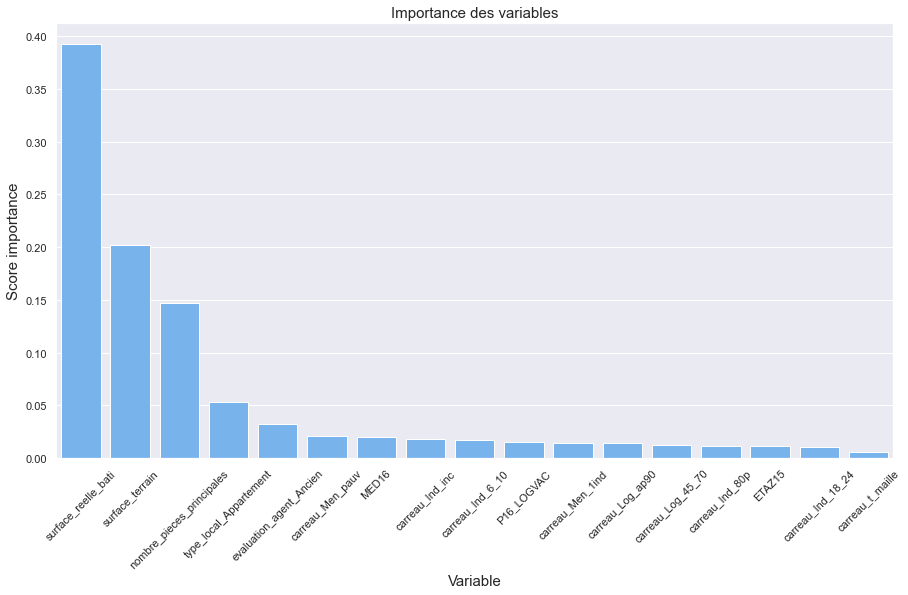

In [702]:
## Importance des variables
importance_df = pd.DataFrame({
    'Variable': X.columns,
    'Importance': optRf.best_estimator_.feature_importances_
}).sort_values('Importance', ascending=False)

barplot_cust(importance_df, x_var="Variable", y_var="Importance", title="Importance des variables", lab=False, label_y='Score importance')

##### V.6. Modèle Adaptative Gradient Boosting

In [703]:
## Optimisation des paramètres du modèle de base (Decision Tree)

start_time = time.time()
parameters_tree = { 'max_depth':[2,3,4,5,6,7,8,9,10],
                    'min_samples_split':[5,10,15,20,40,60,80],
                    'min_samples_leaf':[5,10,15,20,25,40,80,160]
                  }

tree_model = DecisionTreeRegressor(random_state=12)

opTree = GridSearchCV(tree_model, parameters_tree, n_jobs=-1, 
                       cv=8, 
                       scoring='r2',
                       verbose=1, refit=True)

opTree.fit(X_train_s, y_train_s)
print(time.time()-start_time)

## NB 1 : Le modèle de base choisit pour le Adaboost est est un arbre de décision. On effectue au préalable un tuning des paramètres de base
# de ce modèle avant de l'introduire dans le modèle de boosting  

Fitting 8 folds for each of 504 candidates, totalling 4032 fits
7.60459303855896


In [704]:
## Exécution du modèle Adaboost
start_time = time.time()

parameters = {'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.1, 0.2, 0.3],
              'n_estimators': range(50,300,25)
              }

## Cross validation et Modélisation 
adaboost_model =  AdaBoostRegressor(base_estimator=DecisionTreeRegressor(**opTree.best_params_), random_state=12, loss='exponential')

optAdaboost = GridSearchCV(adaboost_model, parameters, n_jobs=-1, 
                       cv=5, 
                       scoring='r2',
                       verbose=1, refit=True)

## Fit sur les paramètres optimisées
optAdaboost.fit(X_train_s, y_train_s)

print(time.time()-start_time)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
147.98701786994934


In [705]:
## Meilleurs paramètres
print(optAdaboost.best_params_)

{'learning_rate': 0.04, 'n_estimators': 100}


In [706]:
## Evaluation du modèle
print("Train :", str(r2_score_custom(optAdaboost, X_train_s, y_train_s))+"%", "Test : ", str(r2_score_custom(optAdaboost, X_test_s, y_test_s))+"%" )

Train : 89.88% Test :  77.79%


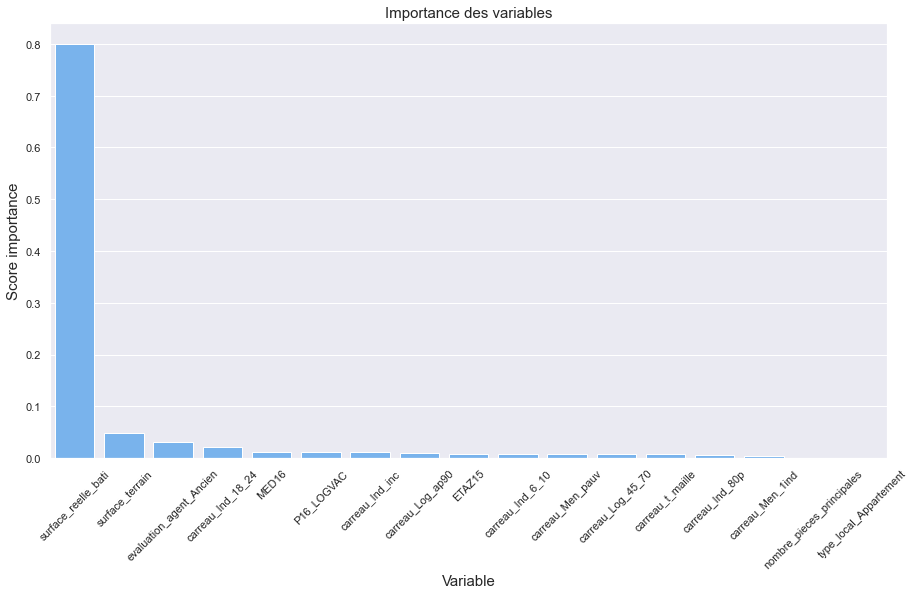

In [707]:
## Importance des variables
importance_df = pd.DataFrame({
    'Variable': X.columns,
    'Importance': optAdaboost.best_estimator_.feature_importances_
}).sort_values('Importance', ascending=False)

barplot_cust(importance_df, x_var="Variable", y_var="Importance", title="Importance des variables", lab=False, label_y='Score importance')

##### V.7. Réseaux de neurones (Perceptron multicouche)

In [708]:
## Paramètres du modèle
tf.random.set_seed(5)
early = EarlyStopping(monitor='val_loss', patience=10)
opt_sgd = tf.keras.optimizers.SGD(learning_rate=0.1)
epochs_ = 100

## Construction du modèle
optNN = Sequential()
optNN.add(Dense(512,activation='relu'))
optNN.add(Dense(256,activation='relu'))
optNN.add(Dense(128,activation='relu'))
optNN.add(Dense(64,activation='relu'))
optNN.add(Dense(1, activation='linear'))
optNN.compile(loss="mean_squared_error", optimizer='adam', metrics=['mse'])

In [709]:
## Exécution du modèle
history = optNN.fit(x=X_train_s,y=y_train_s,epochs=epochs_,batch_size=256,validation_data=(X_test_s,y_test_s), callbacks=[early])

Epoch 1/100
11/11 [==============================] - 1s 17ms/step - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 3/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 5/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 6/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 7/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 8/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0015 - 

In [710]:
## Evaluation du modèle
print("Train :", str(r2_score_custom(optNN, X_train_s, y_train_s))+"%", "Test : ", str(r2_score_custom(optNN, X_test_s, y_test_s))+"%" )

Train : 87.98% Test :  80.41%


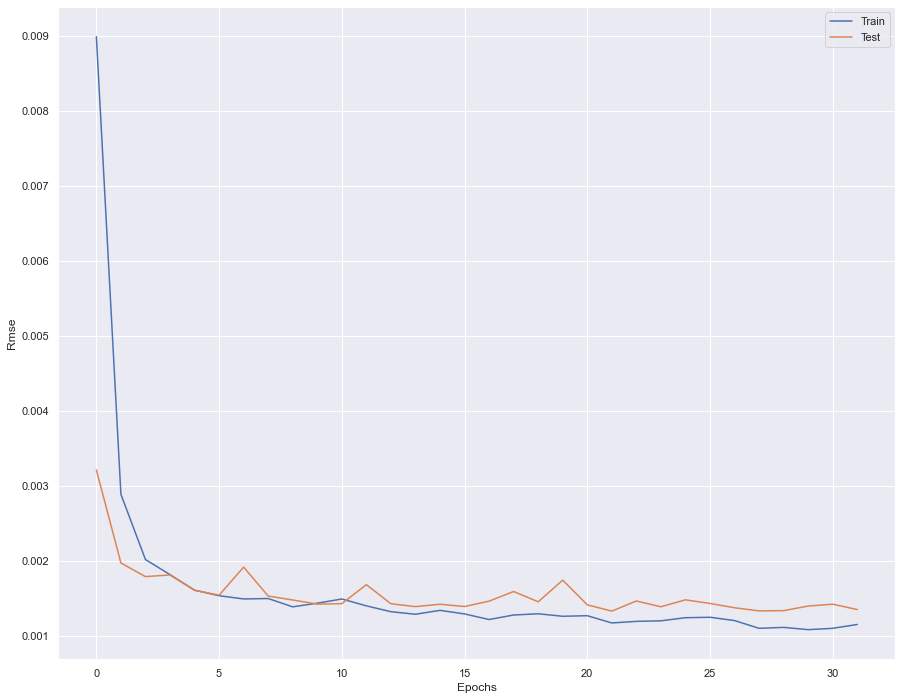

In [711]:
## Construction de la courbe d'apprentissage
results = pd.DataFrame()
results['loss'] = history.history['loss']
results['val_loss'] = history.history['val_loss']

x_axis = range(0, results.shape[0])

fig, ax = plt.subplots(figsize=(15, 12))
ax.plot(x_axis, results['loss'], label='Train')
ax.plot(x_axis, results['val_loss'], label='Test')
ax.set_xlabel('Epochs')
ax.set_ylabel('Rmse')
ax.legend()

##### V.8. Ensemble learning : Stacking des modèles

##### a. Prediction pour modèle de niveau 0

In [712]:
def data_pred(X):
    X_pred=pd.DataFrame()
    X_pred['xgboost_pred'] = optXgb.predict(X)   
    X_pred['rf_pred'] = optRf.predict(X)  
    X_pred['lgb_pred'] = optLgb.predict(X)  
    X_pred['nn_pred'] = optNN.predict(X)
    X_pred['adaboost_pred'] = optAdaboost.predict(X)
    return X_pred

In [713]:
## Préparation des données du modèle de Stacking
X_train_stack = data_pred(X_train_s).values
X_test_stack = data_pred(X_test_s).values

##### b. Construction du méta modèle (niveau 1)

In [714]:
tf.random.set_seed(12)
early = EarlyStopping(monitor='val_loss', patience=2)
opt_sgd = tf.keras.optimizers.SGD(learning_rate=0.11)
epochs_ = 100

## Construction du modèle
optMeta = Sequential()
optMeta.add(Dense(100,activation='selu'))
optMeta.add(Dense(50,activation='relu'))
optMeta.add(Dense(25,activation='relu'))
optMeta.add(Dense(1, activation='linear'))
optMeta.compile(loss="mean_squared_error", optimizer=opt_sgd, metrics=['mse'])

history = optMeta.fit(x=X_train_stack,y=y_train_s,epochs=epochs_,verbose=0,batch_size=256,validation_data=(X_test_stack,y_test_s), callbacks=[early])

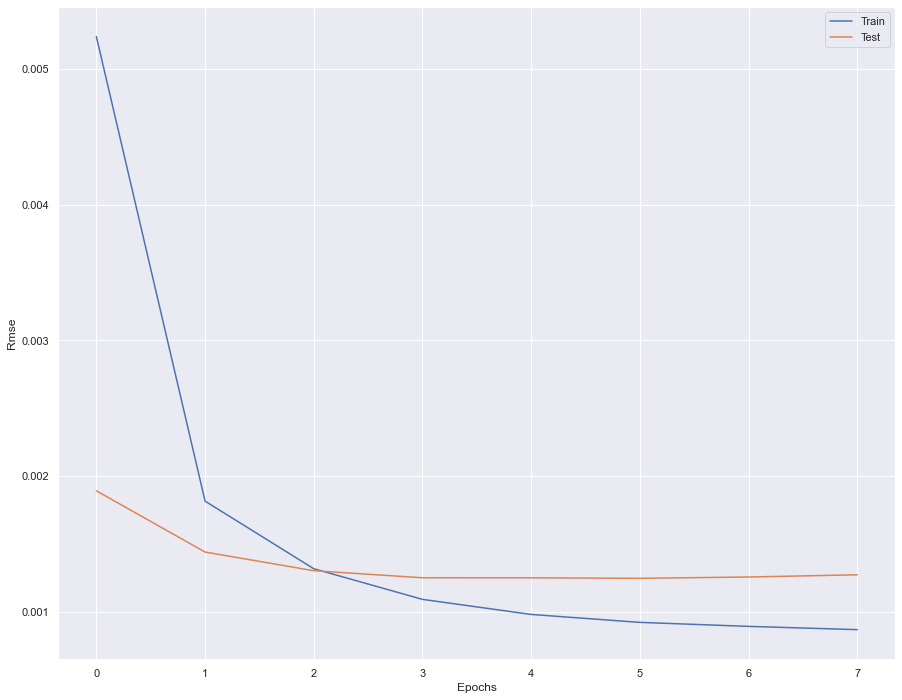

In [715]:
## Construction de la courbe d'apprentissage du méta modèle
results = pd.DataFrame()
results['loss'] = history.history['loss']
results['val_loss'] = history.history['val_loss']

x_axis = range(0, results.shape[0])

fig, ax = plt.subplots(figsize=(15, 12))
ax.plot(x_axis, results['loss'], label='Train')
ax.plot(x_axis, results['val_loss'], label='Test')
ax.set_xlabel('Epochs')
ax.set_ylabel('Rmse')
ax.legend()

In [716]:
## Evaluation du modèle
print("Train :", str(r2_score_custom(optMeta, X_train_stack, y_train_s))+"%", "Test : ", str(r2_score_custom(optMeta, X_test_stack, y_test_s))+"%" )

Train : 90.5% Test :  81.55%


### VI. Comparaison des modèles

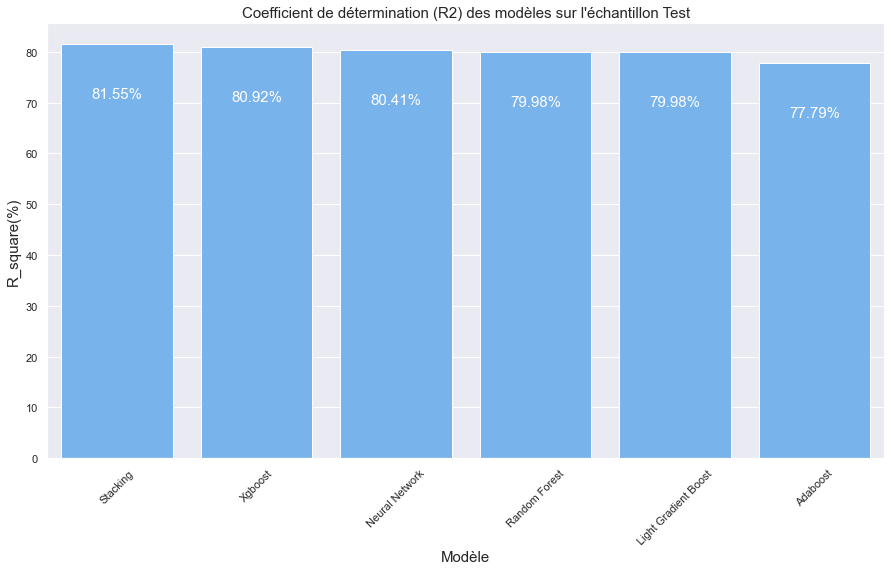

In [717]:
## Peformance des différents modèles
df_r2_score = pd.DataFrame(columns=['variable','R2'])
df_r2_score = df_r2_score.append({'Modèle':'Xgboost','R_square':r2_score_custom(optXgb, X_test_s, y_test_s)}, ignore_index=True)
df_r2_score = df_r2_score.append({'Modèle':'Random Forest','R_square':r2_score_custom(optRf, X_test_s, y_test_s)}, ignore_index=True)
df_r2_score = df_r2_score.append({'Modèle':'Light Gradient Boost','R_square':r2_score_custom(optRf, X_test_s, y_test_s)}, ignore_index=True)
df_r2_score = df_r2_score.append({'Modèle':'Adaboost','R_square':r2_score_custom(optAdaboost, X_test_s, y_test_s)}, ignore_index=True)
df_r2_score = df_r2_score.append({'Modèle':'Neural Network','R_square': r2_score_custom(optNN, X_test_s, y_test_s)}, ignore_index=True)
df_r2_score = df_r2_score.append({'Modèle':'Stacking','R_square': r2_score_custom(optMeta, X_test_stack, y_test_s)}, ignore_index=True)
df_r2_score = df_r2_score.sort_values('R_square',ascending=False)
barplot_cust(df_r2_score, x_var="Modèle", y_var="R_square", title="Coefficient de détermination (R2) des modèles sur l'échantillon Test", lab=True, label_y='R_square(%)')



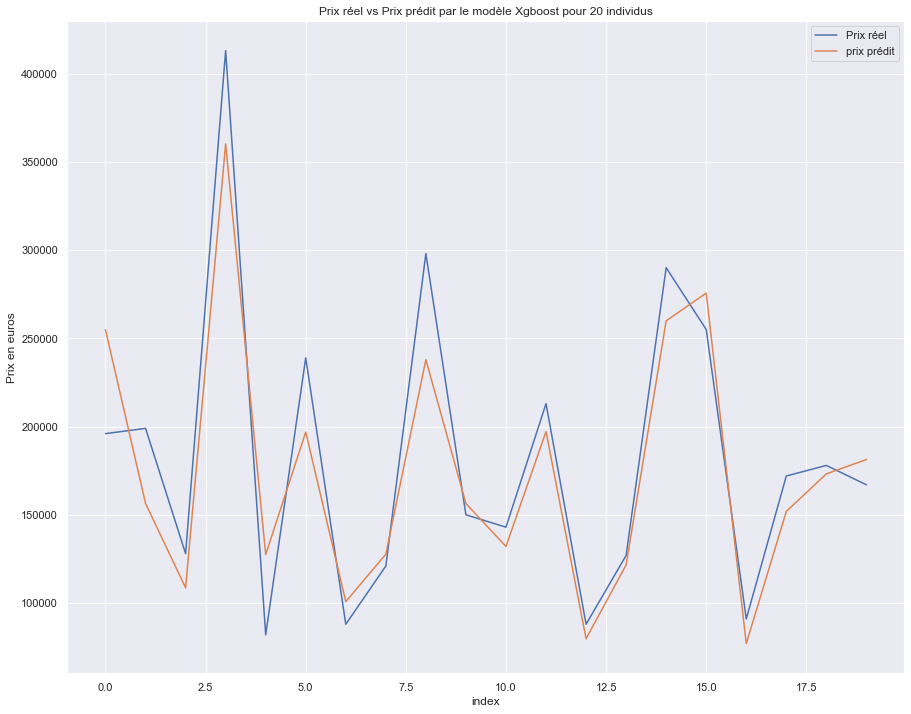

In [718]:
## Représentation du prix réel vs prix prédit pour le modèle Xgboost pour quelques individus

a = optXgb.predict(X_test_s)
b = scaler_mm_y.inverse_transform(a.reshape((-1,1)))

results = pd.DataFrame(b.reshape(b.shape[0]), columns=['pred'])
results['y_test'] = list(y_test)

results = results.iloc[100:120,:]

x_axis = range(0, results.shape[0])

fig, ax = plt.subplots(figsize=(15, 12))
ax.plot(x_axis, results['y_test'], label='Prix réel')
ax.plot(x_axis, results['pred'], label='prix prédit')
ax.set_xlabel('index')
ax.set_ylabel('Prix en euros')
ax.set_title('Prix réel vs Prix prédit par le modèle Xgboost pour 20 individus')
ax.legend()

#### Fin